# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 64 #32
TRAIN_SPLIT_RATIO = 0.99 #0.8 #0.9891 # 1-(60/5*24)/50977

MODE_TRAIN_AE = True #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_52901/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
77704  1695842400000   1595.63   1597.12  1595.32    1595.33   1015.2508   
77705  1695842700000   1595.33   1600.00  1595.32    1598.47   1678.5413   
77706  1695843000000   1598.46   1598.88  1597.97    1598.88    219.2857   
77707  1695843300000   1598.88   1598.94  1598.17    1598.80    272.7304   
77708  1695843600000   1598.80   1598.80  1597.98    1597.99    116.0932   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1735.918623       1735.480578   
1      2023-01-01 00:05:00       1735.918623       1735.480578   
2      2023-01-01 00:10:00       1735.918623       1735.480578   
3      2023-01-01 00:15:00       1735.918623       1735.480578   
4      2023-01-01 00:20:00       1735.918623       1735.480578   
...                    ...               ...               ...   
77704  2023-09-27 19:20:00       1600.310000       1610.475000   
77705  2023-09-27 19:25:00       1599.755000       1610.475000   
77706  2023-09-27 19:30:00       1599.497500       1610.475000   
77707  2023-09-27 19:35:00       1599.152500       1610.475000   
77708  2023-09-27 19:40:00       1598.805000       1610.080000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
77704         1591.53  ...   NaN         NaN            NaN           NaN   
77705         1591.75  ...   NaN         NaN            NaN           NaN   
77706         1591.75  ...   NaN         NaN            NaN           NaN   
77707         1591.75  ...   NaN         NaN            NaN           NaN   
77708         1591.75  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
77704               NaN         0.0               NaN         0.0      0.0   
77705               NaN         0.0               NaN         0.0      0.0   
77706               NaN         0.0               NaN         0.0      0.0   
77707               NaN         0.0               NaN         0.0      0.0   
77708               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
77704   NaN  
77705   NaN  
77706   NaN  
77707   NaN  
77708   NaN  

[77709 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              77675
Event               77675
Country             77675
keep                77675
date                77675
Length: 65, dtype: int64

on 77709 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
77704  1695842400000   1595.63   1597.12  1595.32    1595.33   1015.2508   
77705  1695842700000   1595.33   1600.00  1595.32    1598.47   1678.5413   
77706  1695843000000   1598.46   1598.88  1597.97    1598.88    219.2857   
77707  1695843300000   1598.88   1598.94  1598.17    1598.80    272.7304   
77708  1695843600000   1598.80   1598.80  1597.98    1597.99    116.0932   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1735.918623       1735.480578   
1      2023-01-01 00:05:00       1735.918623       1735.480578   
2      2023-01-01 00:10:00       1735.918623       1735.480578   
3      2023-01-01 00:15:00       1735.918623       1735.480578   
4      2023-01-01 00:20:00       1735.918623       1735.480578   
...                    ...               ...               ...   
77704  2023-09-27 19:20:00       1600.310000       1610.475000   
77705  2023-09-27 19:25:00       1599.755000       1610.475000   
77706  2023-09-27 19:30:00       1599.497500       1610.475000   
77707  2023-09-27 19:35:00       1599.152500       1610.475000   
77708  2023-09-27 19:40:00       1598.805000       1610.080000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...   1.0         0.0            0.0           0.0   
1             1194.71  ...   1.0         0.0            0.0           0.0   
2             1194.71  ...   1.0         0.0            0.0           0.0   
3             1194.71  ...   1.0         0.0            0.0           0.0   
4             1194.71  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
77704         1591.53  ...   NaN         NaN            NaN           NaN   
77705         1591.75  ...   NaN         NaN            NaN           NaN   
77706         1591.75  ...   NaN         NaN            NaN           NaN   
77707         1591.75  ...   NaN         NaN            NaN           NaN   
77708         1591.75  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
77704               NaN         0.0               NaN         0.0      0.0   
77705               NaN         0.0               NaN         0.0      0.0   
77706               NaN         0.0               NaN         0.0      0.0   
77707               NaN         0.0               NaN         0.0      0.0   
77708               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
77704                  NaN  
77705                  NaN  
77706                  NaN  
77707                  NaN  
77708                  NaN  

[77709 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       2024
delta_event_real    2024
delta_event_pred    2024
Previous_num        2024
Actual_num          2024
Event               2024
Date                2024
Previous            2024
Consensus           2024
Actual              2024
Country             2024
Time (ET)           2024
keep                2024
date                2024
dtype: int64

on 77709 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
77704   1595.63   1597.12  1595.32    1595.33   1015.2508   
77705   1595.33   1600.00  1595.32    1598.47   1678.5413   
77706   1598.46   1598.88  1597.97    1598.88    219.2857   
77707   1598.88   1598.94  1598.17    1598.80    272.7304   
77708   1598.80   1598.80  1597.98    1597.99    116.0932   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1735.918623       1735.480578   
1      2023-01-01 00:05:00       1735.918623       1735.480578   
2      2023-01-01 00:10:00       1735.918623       1735.480578   
3      2023-01-01 00:15:00       1735.918623       1735.480578   
4      2023-01-01 00:20:00       1735.918623       1735.480578   
...                    ...               ...               ...   
77704  2023-09-27 19:20:00       1600.310000       1610.475000   
77705  2023-09-27 19:25:00       1599.755000       1610.475000   
77706  2023-09-27 19:30:00       1599.497500       1610.475000   
77707  2023-09-27 19:35:00       1599.152500       1610.475000   
77708  2023-09-27 19:40:00       1598.805000       1610.080000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0             1194.71          1194.71  ...  1196.096667  1196.096667   
1             1194.71          1194.71  ...  1195.801420  1195.801420   
2             1194.71          1194.71  ...  1195.648641  1195.648641   
3             1194.71          1194.71  ...  1195.575250  1195.575250   
4             1194.71          1194.71  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
77704         1591.53          1595.49  ...  1608.236945  1672.959195   
77705         1591.75          1596.93  ...  1608.231533  1672.943450   
77706         1591.75          1596.93  ...  1608.229375  1672.941210   
77707         1591.75          1596.93  ...  1608.227861  1672.936970   
77708         1591.75          1596.93  ...  1608.226474  1672.930845   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
77704  1778.151604  1629.676535   1725.239753         -0.772385 -0.081431   
77705  1778.140983  1629.666742   1725.237695         -0.753705 -0.079306   
77706  1778.142070  1629.664624   1725.237428         -0.751268 -0.079029   
77707  1778.141459  1629.662637   1725.237095         -0.751743 -0.079082   
77708  1778.142845  1629.661538   1725.236953         -0.756560 -0.079629   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205209e+08      534998.0       18.612228  
1      1.205209e+08      534998.0       18.612228  
2      1.205209e+08      534998.0       18.612228  
3      1.205209e+08      534998.0       18.612228  
4      1.205209e+08      534998.0       18.612228  
...             ...           ...             ...  
77704  1.202324e+08      461615.0       17.761524  
77705  1.202324e+08      461615.0       17.761524  
77706  1.202324e+08      461615.0       17.761524  
77707  1.202324e+08      461615.0       17.761524  
77708  1.202324e+08      461615.0       17.761524  

[77709 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
77704  4.703  4281.120117  106.626999
77705  4.703  4281.120117  106.626999
77706  4.703  4281.120117  106.626999
77707  4.703  4281.120117  106.626999
77708  4.703  4281.120117  106.626999

[77709 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

77709

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

76932

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
77704  1695842400000   1595.63   1597.12  1595.32    1595.33   1015.2508   
77705  1695842700000   1595.33   1600.00  1595.32    1598.47   1678.5413   
77706  1695843000000   1598.46   1598.88  1597.97    1598.88    219.2857   
77707  1695843300000   1598.88   1598.94  1598.17    1598.80    272.7304   
77708  1695843600000   1598.80   1598.80  1597.98    1597.99    116.0932   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1735.918623       1735.480578   
1      2023-01-01 00:05:00       1735.918623       1735.480578   
2      2023-01-01 00:10:00       1735.918623       1735.480578   
3      2023-01-01 00:15:00       1735.918623       1735.480578   
4      2023-01-01 00:20:00       1735.918623       1735.480578   
...                    ...               ...               ...   
77704  2023-09-27 19:20:00       1600.310000       1610.475000   
77705  2023-09-27 19:25:00       1599.755000       1610.475000   
77706  2023-09-27 19:30:00       1599.497500       1610.475000   
77707  2023-09-27 19:35:00       1599.152500       1610.475000   
77708  2023-09-27 19:40:00       1598.805000       1610.080000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
77704         1591.53  ...         NaN            NaN           NaN   
77705         1591.75  ...         NaN            NaN           NaN   
77706         1591.75  ...         NaN            NaN           NaN   
77707         1591.75  ...         NaN            NaN           NaN   
77708         1591.75  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
77704               NaN         0.0               NaN         0.0      0.0   
77705               NaN         0.0               NaN         0.0      0.0   
77706               NaN         0.0               NaN         0.0      0.0   
77707               NaN         0.0               NaN         0.0      0.0   
77708               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
77704                  NaN  False  
77705                  NaN  False  
77706                  NaN  False  
77707                  NaN  False  
77708                  NaN  False  

[77709 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
76928  1695609600000   1578.09   1578.63  1577.33    1578.62    475.9699   
76929  1695609900000   1578.63   1578.63  1578.03    1578.04    382.2966   
76930  1695610200000   1578.03   1578.78  1577.84    1578.78    226.4795   
76931  1695610500000   1578.77   1581.41  1578.77    1580.17    382.5008   
76932  1695610800000   1580.17   1580.99  1580.00    1580.01    202.0351   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1735.918623       1735.480578   
1      2023-01-01 00:05:00       1735.918623       1735.480578   
2      2023-01-01 00:10:00       1735.918623       1735.480578   
3      2023-01-01 00:15:00       1735.918623       1735.480578   
4      2023-01-01 00:20:00       1735.918623       1735.480578   
...                    ...               ...               ...   
76928  2023-09-25 02:40:00       1574.217500       1577.120000   
76929  2023-09-25 02:45:00       1574.217500       1577.120000   
76930  2023-09-25 02:50:00       1574.217500       1577.120000   
76931  2023-09-25 02:55:00       1573.767500       1577.120000   
76932  2023-09-25 03:00:00       1573.765000       1577.120000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
76928        1578.680  ...         NaN            NaN           NaN   
76929        1578.810  ...         NaN            NaN           NaN   
76930        1580.385  ...         NaN            NaN           NaN   
76931        1581.675  ...         NaN            NaN           NaN   
76932        1581.675  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
76928               NaN         0.0               NaN         0.0      0.0   
76929               NaN         0.0               NaN         0.0      0.0   
76930               NaN         0.0               NaN         0.0      0.0   
76931               NaN         0.0               NaN         0.0      0.0   
76932               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
76928                  NaN   True  
76929                  NaN   True  
76930                  NaN   True  
76931                  NaN   True  
76932                  NaN   True  

[76933 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
76933  1695611100000   1580.01   1581.91  1580.00    1581.61    465.7776   
76934  1695611400000   1581.62   1582.19  1581.24    1581.24    366.8242   
76935  1695611700000   1581.25   1581.40  1580.52    1580.72    315.0075   
76936  1695612000000   1580.72   1580.73  1580.17    1580.18    224.6615   
76937  1695612300000   1580.17   1580.18  1578.97    1579.56    373.7104   
...              ...       ...       ...      ...        ...         ...   
77704  1695842400000   1595.63   1597.12  1595.32    1595.33   1015.2508   
77705  1695842700000   1595.33   1600.00  1595.32    1598.47   1678.5413   
77706  1695843000000   1598.46   1598.88  1597.97    1598.88    219.2857   
77707  1695843300000   1598.88   1598.94  1598.17    1598.80    272.7304   
77708  1695843600000   1598.80   1598.80  1597.98    1597.99    116.0932   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
76933  2023-09-25 03:05:00         1573.8375          1577.120   
76934  2023-09-25 03:10:00         1574.6075          1577.120   
76935  2023-09-25 03:15:00         1577.4200          1577.120   
76936  2023-09-25 03:20:00         1577.1425          1577.120   
76937  2023-09-25 03:25:00         1577.1425          1577.120   
...                    ...               ...               ...   
77704  2023-09-27 19:20:00         1600.3100          1610.475   
77705  2023-09-27 19:25:00         1599.7550          1610.475   
77706  2023-09-27 19:30:00         1599.4975          1610.475   
77707  2023-09-27 19:35:00         1599.1525          1610.475   
77708  2023-09-27 19:40:00         1598.8050          1610.080   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
76933        1581.675  ...         NaN            NaN           NaN   
76934        1581.675  ...         NaN            NaN           NaN   
76935        1580.575  ...         NaN            NaN           NaN   
76936        1580.290  ...         NaN            NaN           NaN   
76937        1580.055  ...         NaN            NaN           NaN   
...               ...  ...         ...            ...           ...   
77704        1591.530  ...         NaN            NaN           NaN   
77705        1591.750  ...         NaN            NaN           NaN   
77706        1591.750  ...         NaN            NaN           NaN   
77707        1591.750  ...         NaN            NaN           NaN   
77708        1591.750  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
76933               NaN         0.0               NaN         0.0      0.0   
76934               NaN         0.0               NaN         0.0      0.0   
76935               NaN         0.0               NaN         0.0      0.0   
76936               NaN         0.0               NaN         0.0      0.0   
76937               NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
77704               NaN         0.0               NaN         0.0      0.0   
77705               NaN         0.0               NaN         0.0      0.0   
77706               NaN         0.0               NaN         0.0      0.0   
77707               NaN         0.0               NaN         0.0      0.0   
77708               NaN         0.0               NaN         0.0      0.0   

       date  train  
76933   NaN  False  
76934   NaN  False  
76935   NaN  False  
76936   NaN  False  
76937   NaN  False  
...     ...    ...  
77704   NaN  False  
77705   NaN  False  
77706   NaN  False  
77707   NaN  False  
77708   NaN  False  

[776 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(76846, 72, 102) (76846, 15)
(689, 72, 102) (689, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([0.99834942, 0.99750199, 0.99636366, 0.99743243, 0.99800792,
       0.99898182, 0.99933597, 0.99784982, 0.99790673, 0.99798895,
       0.99798895, 0.99833045, 0.99796365, 0.99843163, 0.99931068])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99941266, 0.99864848, 0.99700013, ..., 0.99664014, 0.99698118,
        0.99661488],
       [0.99923537, 0.99758605, 0.99673927, ..., 0.99756709, 0.99720058,
        0.9976682 ],
       [0.99834942, 0.99750199, 0.99636366, ..., 0.99796365, 0.99843163,
        0.99931068]])

In [39]:
seq_y

array([0.99834942, 0.99750199, 0.99636366, 0.99743243, 0.99800792,
       0.99898182, 0.99933597, 0.99784982, 0.99790673, 0.99798895,
       0.99798895, 0.99833045, 0.99796365, 0.99843163, 0.99931068])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99941266, 0.99864848, 0.99700013, ..., 0.99664014, 0.99698118,
        0.99661488],
       [0.99923537, 0.99758605, 0.99673927, ..., 0.99756709, 0.99720058,
        0.9976682 ],
       [0.99834942, 0.99750199, 0.99636366, ..., 0.99796365, 0.99843163,
        0.99931068]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(76846, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(76846, 72, 102) (76846, 15)
(689, 72, 102) (689, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99941266, 0.99864848, 0.99700013, ..., 0.99664014, 0.99698118,
        0.99661488],
       [0.99923537, 0.99758605, 0.99673927, ..., 0.99756709, 0.99720058,
        0.9976682 ],
       [0.99834942, 0.99750199, 0.99636366, ..., 0.99796365, 0.99843163,
        0.99931068]])

In [47]:
np.mean(y_train_sca)

-3.707818853875697e-14

In [48]:
np.std(y_train_sca)

1.0000000000000002

In [49]:
np.mean(y_test_sca)

0.025382923463584464

In [50]:
np.std(y_test_sca)

0.6685606193331847

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1735.918623       1735.480578   
1    1195.38   1196.31   1196.69  1194.90       1735.918623       1735.480578   
2    1194.55   1195.38   1195.81  1194.55       1735.918623       1735.480578   
3    1195.98   1194.55   1195.98  1194.31       1735.918623       1735.480578   
4    1196.06   1195.98   1196.37  1195.97       1735.918623       1735.480578   
5    1196.61   1196.06   1196.70  1196.06       1735.918623       1735.480578   
6    1194.36   1196.62   1196.62  1193.72       1735.918623       1735.480578   
7    1194.22   1194.37   1194.43  1192.72       1735.918623       1735.480578   
8    1193.64   1194.22   1194.22  1193.02       1735.918623       1735.480578   
9    1194.64   1193.64   1195.06  1193.63       1735.918623       1735.480578   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1738.546941   
1         1194.71          1194.71           1738.546941   
2         1194.71          1194.71           1738.546941   
3         1194.71          1194.71           1738.546941   
4         1194.71          1194.71           1738.546941   
5         1194.71          1194.71           1738.546941   
6         1194.71          1194.71           1738.546941   
7         1194.71          1194.71           1738.546941   
8         1194.71          1194.71           1738.546941   
9         1194.71          1194.71           1738.546941   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   
1           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   
2           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   
3           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   
4           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   
5           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   
6           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   
7           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   
8           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   
9           1731.544103  ...  1.205209e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(5532912, 102)

In [57]:
X_train[:,-1,:].shape

(76846, 102)

In [58]:
X_test[:,-1,:].shape

(689, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.011343 -0.014108 -0.066724  0.077838         -0.047719   
1       0.011343 -0.041660 -0.078645  0.050212         -0.080276   
2       0.011343  0.021344 -0.056798  0.085745         -0.073942   
3       0.011343  0.102141  0.011791  0.092646         -0.005786   
4       0.011343 -0.067268 -0.076659  0.025521         -0.047170   
...          ...       ...       ...       ...               ...   
77530   0.011343  0.339485  0.251195  0.104501          0.658415   
77531   0.011343  0.257260  0.210071 -0.326001          0.800150   
77532   0.011343  0.088535 -0.001186 -0.077468          0.841617   
77533   0.011343 -0.092852 -0.058736 -0.145577          0.766199   
77534   0.011343 -0.123042 -0.052795 -0.058569          0.654237   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.011865       -0.148320        -0.041649   
1             -0.024882       -0.179209        -0.074140   
2             -0.018871       -0.164894        -0.040168   
3              0.041956       -0.080840         0.048196   
4             -0.011523       -0.154740        -0.029494   
...                 ...             ...              ...   
77530          1.072027        0.393838         0.273640   
77531          1.240532        0.308045         0.146790   
77532          1.293621        0.380576         0.211150   
77533          1.221661        0.282264         0.108082   
77534          1.064233        0.156317        -0.023959   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  8.484638              7.925632  ...  0.366867  1.365879   
1                  8.472139              7.913898  ...  0.000782  1.414060   
2                  8.474184              7.915817  ...  0.000782  1.414060   
3                  8.494874              7.935242  ...  0.000782  1.414060   
4                  8.476683              7.918164  ...  0.000782  1.414060   
...                     ...                   ...  ...       ...       ...   
77530             -0.166421              0.019639  ...  0.000782 -1.413906   
77531             -0.127873              0.056002  ...  0.000782 -1.413906   
77532             -0.115728              0.067545  ...  0.000782 -1.413906   
77533             -0.132190              0.051899  ...  0.000782 -1.413906   
77534             -0.153279              0.031854  ...  0.000782 -1.413906   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
0         0.879279    -1.101953          1.418565          0.268497 -0.05419   
1         0.879279    -1.101953          1.418565          0.268497 -0.05419   
2         0.879279    -1.101953          1.418565          0.268497 -0.05419   
3         0.879279    -1.101953          1.418565          0.268497 -0.05419   
4         0.879279    -1.101953          1.418565          0.268497 -0.05419   
...            ...          ...               ...               ...      ...   
77530    -0.317548     1.381702          1.176265         -0.842665 -0.05419   
77531    -0.317548     1.381702          1.176265         -0.842665 -0.05419   
77532    -0.317548     1.381702          1.176265         -0.842665 -0.05419   
77533    -0.317548     1.381702          1.176265         -0.842665 -0.05419   
77534    -0.317548     1.381702          1.176265         -0.842665 -0.05419   

       event_pred  event_real  TRAIN  
0             0.0         0.0    1.0  
1             0.0         0.0    1.0  
2             0.0         0.0    1.0  
3             0.0         0.0    1.0  
4             0.0         0.0    1.0  
...           ...         ...    ...  
77530         0.0         0.0    0.0  
77531         0.0         0.0    0.0  
77532         0.0         0.0    0.0  
77533         0.0         0.0    0.0  
77534         0.0         0.0    0.0  

[77535 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  7.684600e+04  76846.000000  76846.000000  76846.000000   
mean   1.134283e-02      0.011197      0.011357      0.011142   
std    1.216916e-14      0.171792      0.135573      0.133167   
min    1.134283e-02     -5.689530     -0.079638     -5.632406   
25%    1.134283e-02     -0.051321     -0.063561     -0.016154   
50%    1.134283e-02      0.011499     -0.025703      0.049509   
75%    1.134283e-02      0.072528      0.038522      0.087754   
max    1.134283e-02     11.078037     11.318269      0.104501   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      76846.000000      76846.000000    76846.000000     76846.000000   
mean           0.005632          0.005409        0.010407         0.010984   
std            0.636202          0.687451        0.364443         0.233630   
min           -5.849772         -6.043093       -4.699587        -3.926151   
25%           -0.207019         -0.226224       -0.136720        -0.085137   
50%            0.016281          0.020410        0.022015         0.015602   
75%            0.231363          0.270231        0.170941         0.113923   
max            9.765948         10.003393        6.532060         6.105863   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          76846.000000          76846.000000  ...  76846.000000   
mean              -0.001971             -0.001688  ...      0.000219   
std                0.973490              0.977327  ...      1.000215   
min               -3.515237             -3.016406  ...     -1.413663   
25%               -0.382740             -0.439840  ...     -0.999382   
50%                0.000563             -0.024298  ...      0.000782   
75%                0.283417              0.372033  ...      1.000946   
max                8.512405              7.951701  ...      1.415227   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  76846.000000  76846.000000  76846.000000      76846.000000   
mean      -0.000591      0.000123      0.000256         -0.000377   
std        0.999798      1.000148      0.999866          0.999629   
min       -1.413906     -1.277328     -1.374947         -1.394355   
25%       -0.999760     -1.277328     -1.101953         -1.051549   
50%        0.000077     -0.317548      0.003377         -0.045323   
75%        0.999914      0.879279      1.108708          1.005674   
max        1.414060      1.411916      1.381702          1.447653   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      76846.000000  7.684600e+04  76846.000000  76846.000000  76846.0  
mean          -0.000722 -1.072573e-17      0.000000      0.000000      1.0  
std            1.000377  1.000007e+00      1.000007      1.000007      0.0  
min           -1.423133 -5.418978e-02    -69.302778    -69.302778      1.0  
25%           -1.035595 -5.418978e-02      0.000000      0.000000      1.0  
50%           -0.014965 -5.418978e-02      0.000000      0.000000      1.0  
75%            1.005665 -5.418978e-02      0.000000      0.000000      1.0  
max            1.393203  1.845367e+01     69.302778     69.302778      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  6.890000e+02  689.000000  689.000000  689.000000        689.000000   
mean   1.134283e-02    0.010132   -0.017336    0.044385         -0.016243   
std    1.371427e-16    0.099931    0.070000    0.077174          0.487120   
min    1.134283e-02   -0.538283   -0.079638   -0.447506         -1.727868   
25%    1.134283e-02   -0.040904   -0.068447    0.020791         -0.140021   
50%    1.134283e-02    0.011499   -0.037797    0.067472          0.027763   
75%    1.134283e-02    0.063447    0.008247    0.098506          0.191473   
max    1.134283e-02    0.577520    0.492039    0.104501          1.686026   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        689.000000      689.000000       689.000000   
mean          -0.027505        0.029542         0.020362   
std            0.466164        0.274801         0.158565   
min           -1.658824       -1.019043        -0.657334   
25%           -0.141666       -0.091318        -0.057592   
50%            0.036702        0.042808         0.018331   
75%            0.181010        0.179304         0.103983   
max            1.293621        1.153030         0.857708   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            689.000000            689.000000  ...  689.000000   
mean              -0.034119              0.184915  ...   -0.167644   
std                0.173036              0.186829  ...    1.003685   
min               -0.568344             -0.374453  ...   -1.413663   
25%               -0.119390              0.128097  ...   -1.224163   
50%               -0.001406              0.220355  ...   -0.365303   
75%                0.044333              0.274180  ...    0.708005   
max                0.325212              0.559289  ...    1.415227   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  689.000000   689.000000   689.000000        689.000000   
mean    -0.055299     0.634542     0.907506          0.978459   
std      0.981869     0.688735     0.550494          0.166743   
min     -1.413906    -0.317548     0.003377          0.737151   
25%     -0.999760    -0.317548     0.003377          0.737151   
50%      0.000077     0.879279     1.108708          0.977486   
75%      0.999914     1.411916     1.381702          1.176265   
max      1.414060     1.411916     1.381702          1.176265   

       day_in_month_sin       day_off  event_pred  event_real  TRAIN  
count        689.000000  6.890000e+02       689.0       689.0  689.0  
mean          -1.036471 -5.418978e-02         0.0         0.0    0.0  
std            0.150278  5.069072e-16         0.0         0.0    0.0  
min           -1.234474 -5.418978e-02         0.0         0.0    0.0  
25%           -1.234474 -5.418978e-02         0.0         0.0    0.0  
50%           -1.061438 -5.418978e-02         0.0         0.0    0.0  
75%           -0.842665 -5.418978e-02         0.0         0.0    0.0  
max           -0.842665 -5.418978e-02         0.0         0.0    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

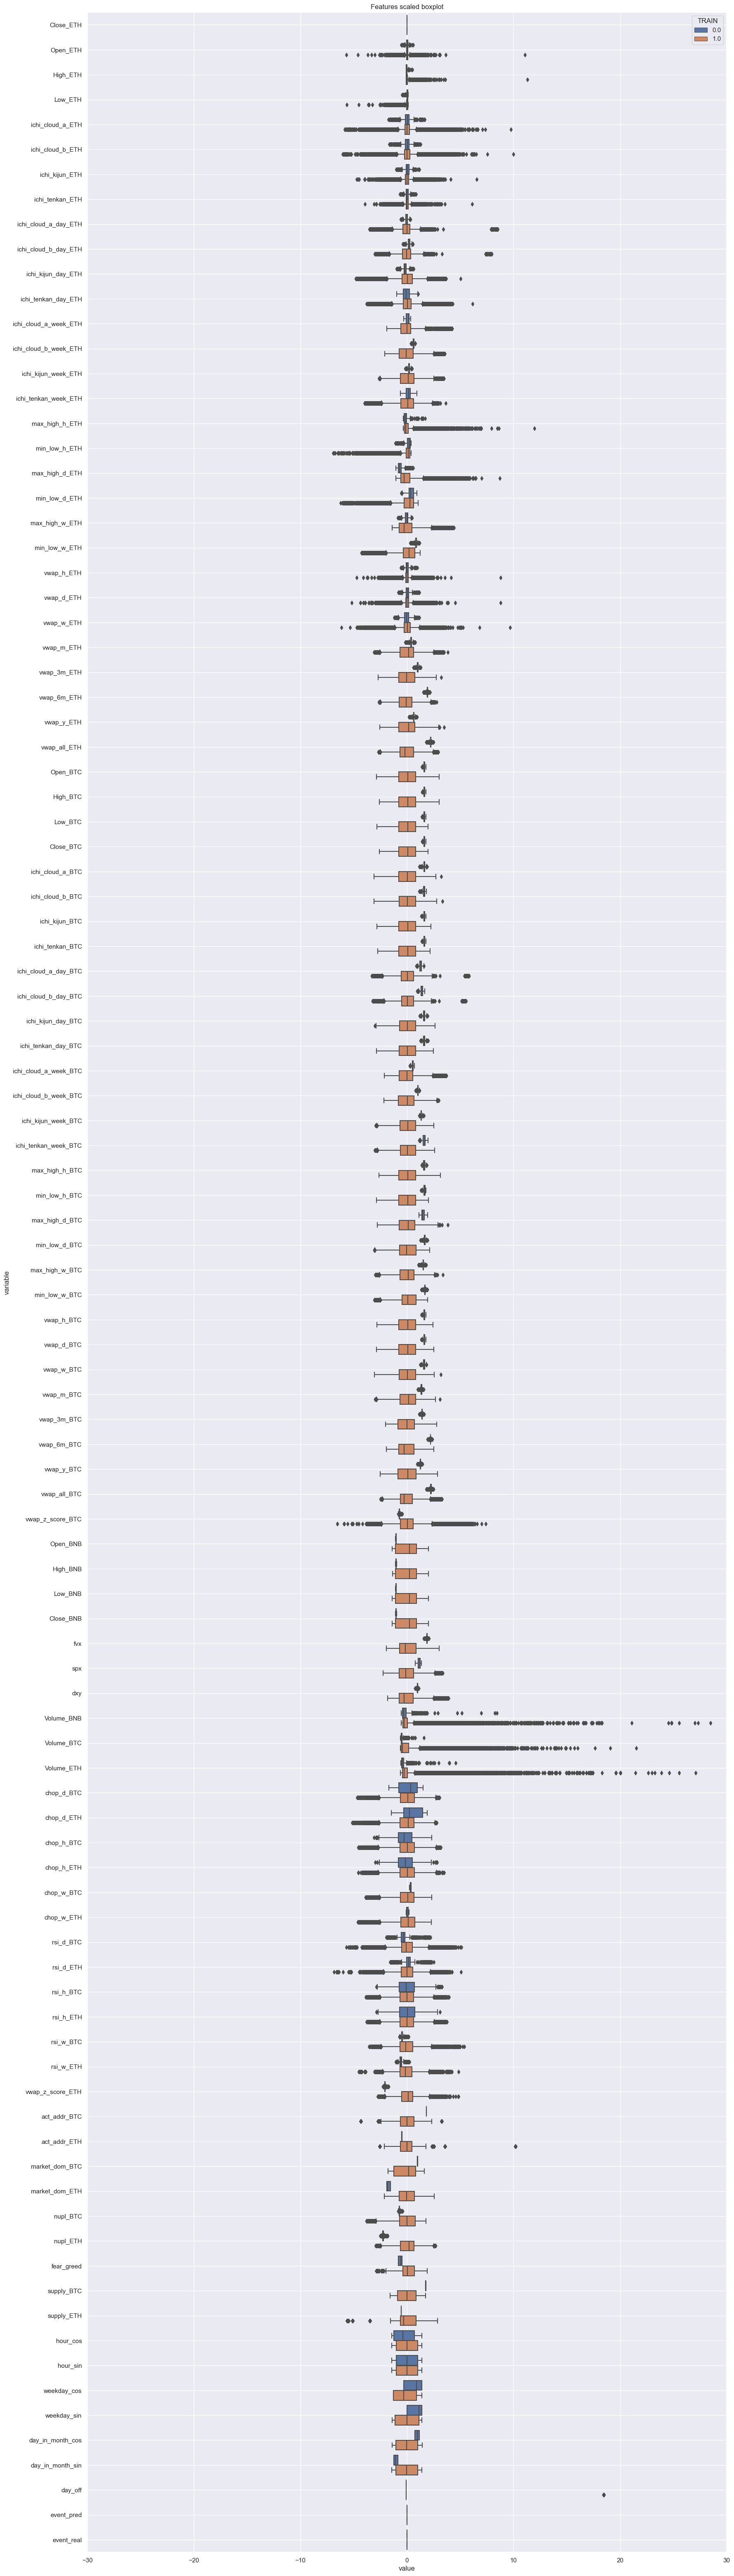

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

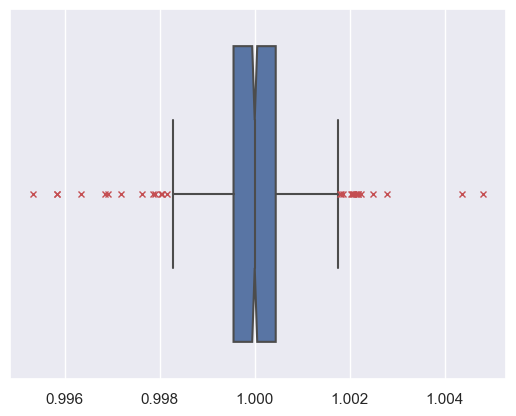

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


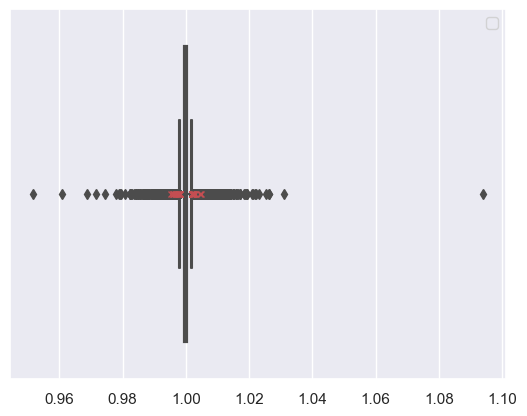

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

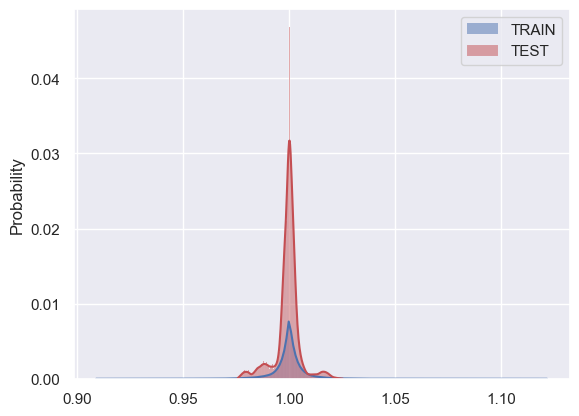

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(76846, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(76846, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10571675],
       [-0.02804099],
       [-0.19936463],
       ...,
       [-0.15588132],
       [-0.20014389],
       [-0.42134098]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(76846, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

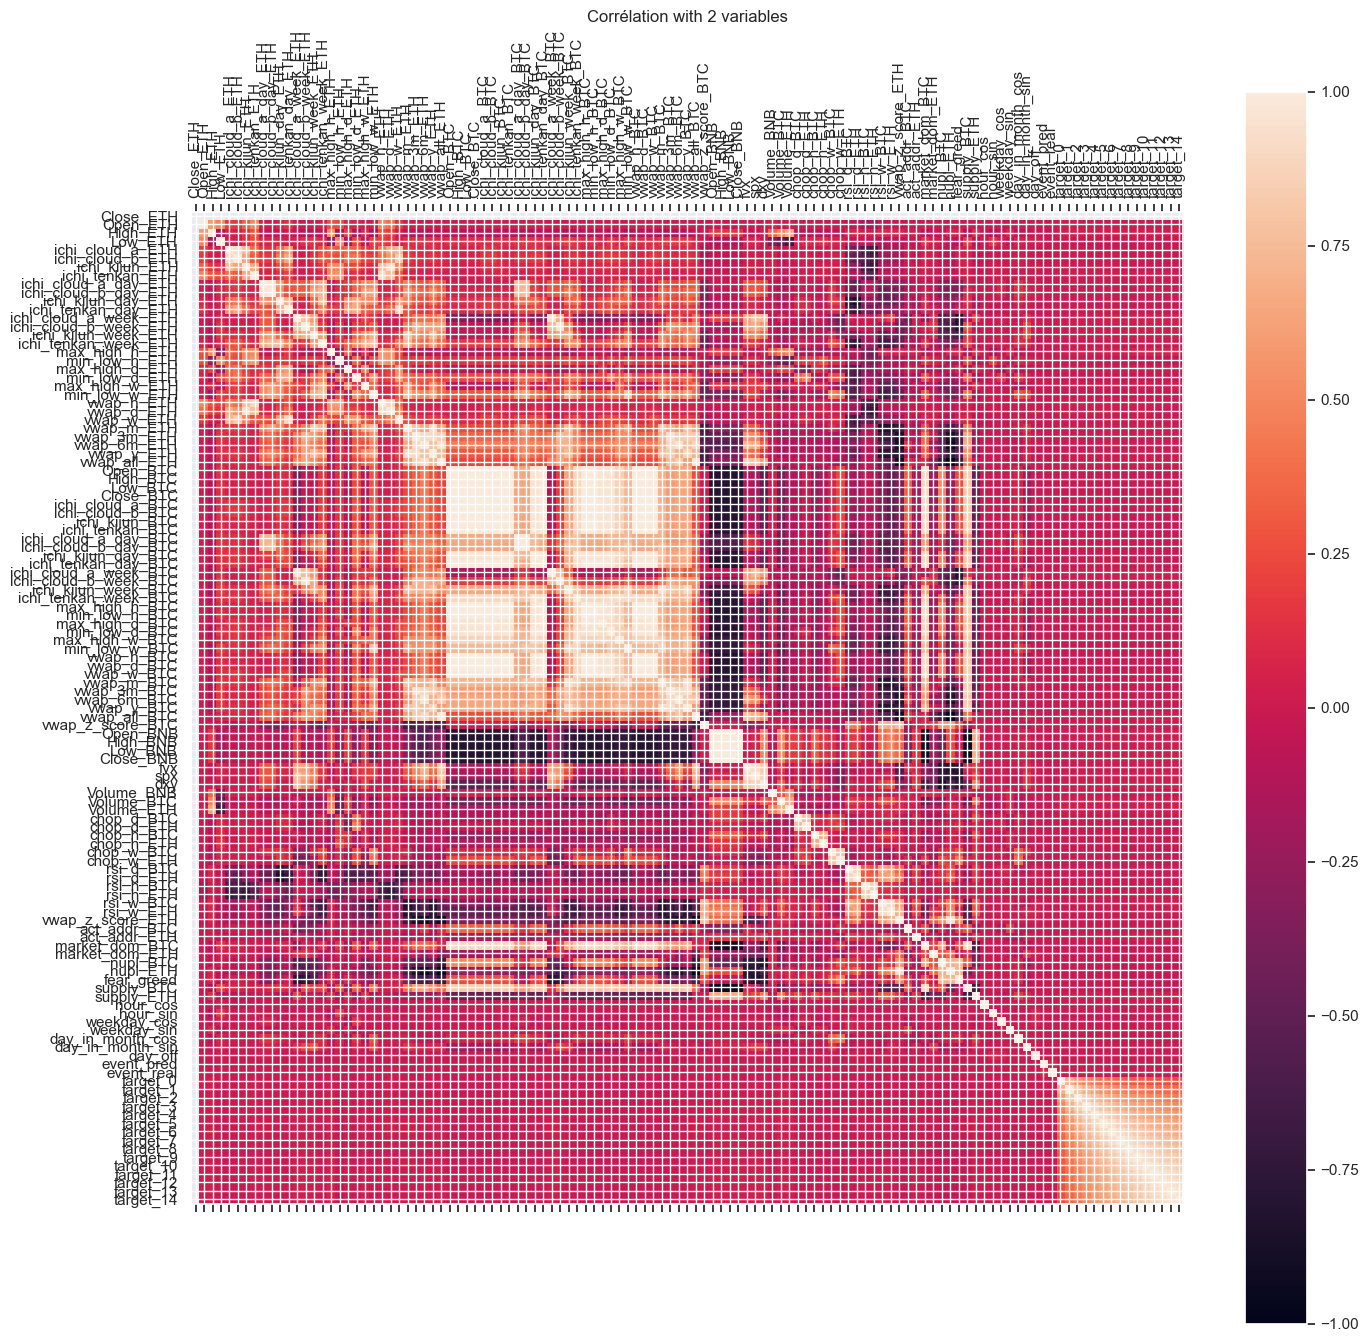

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


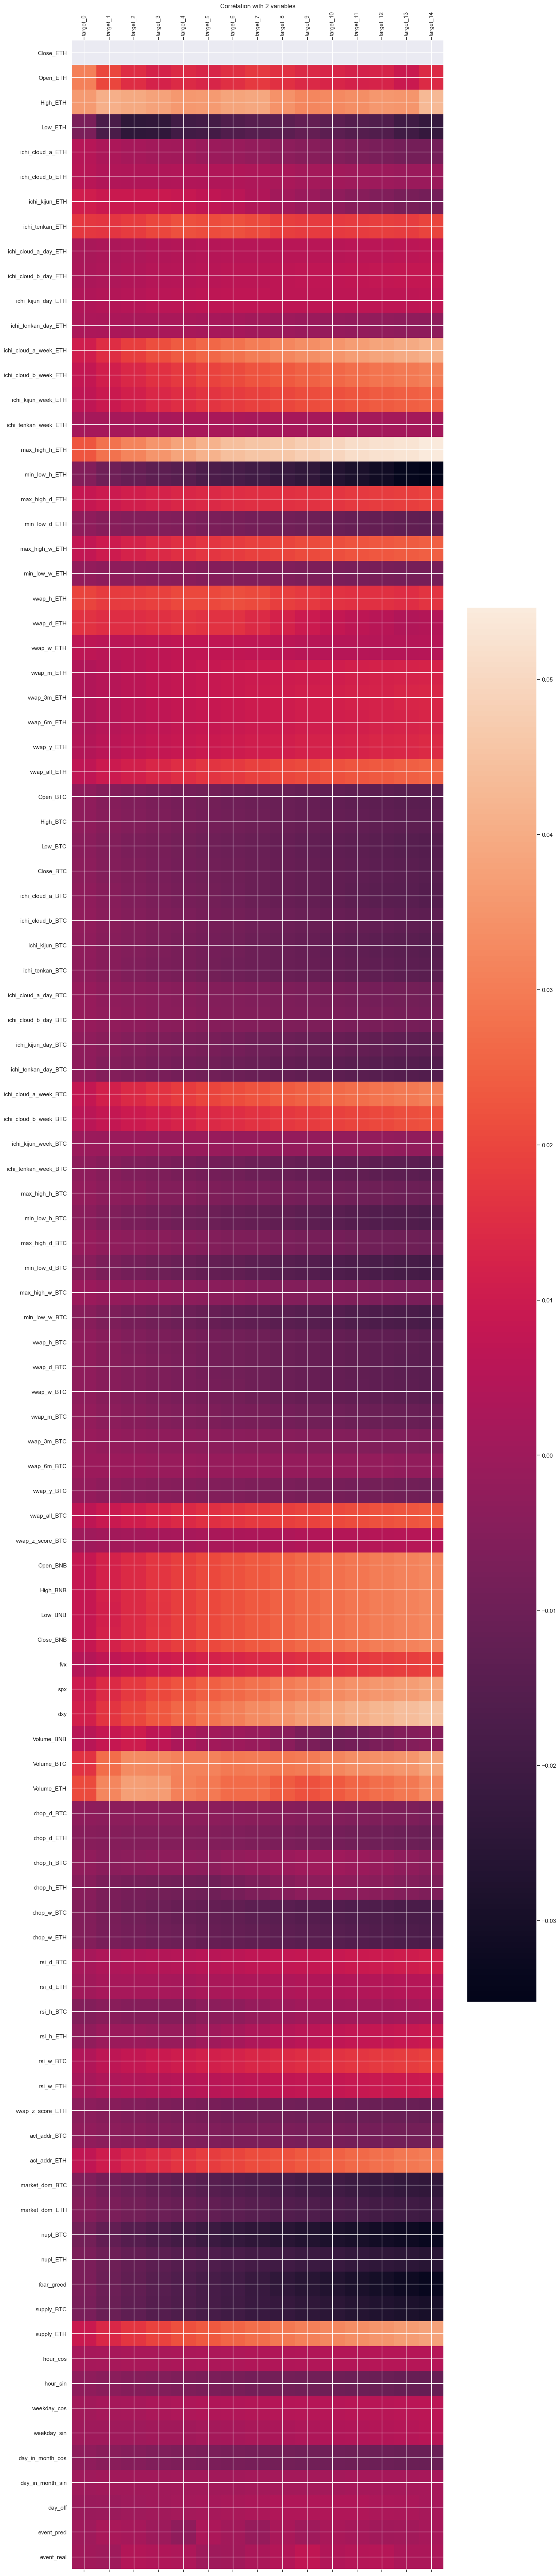

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


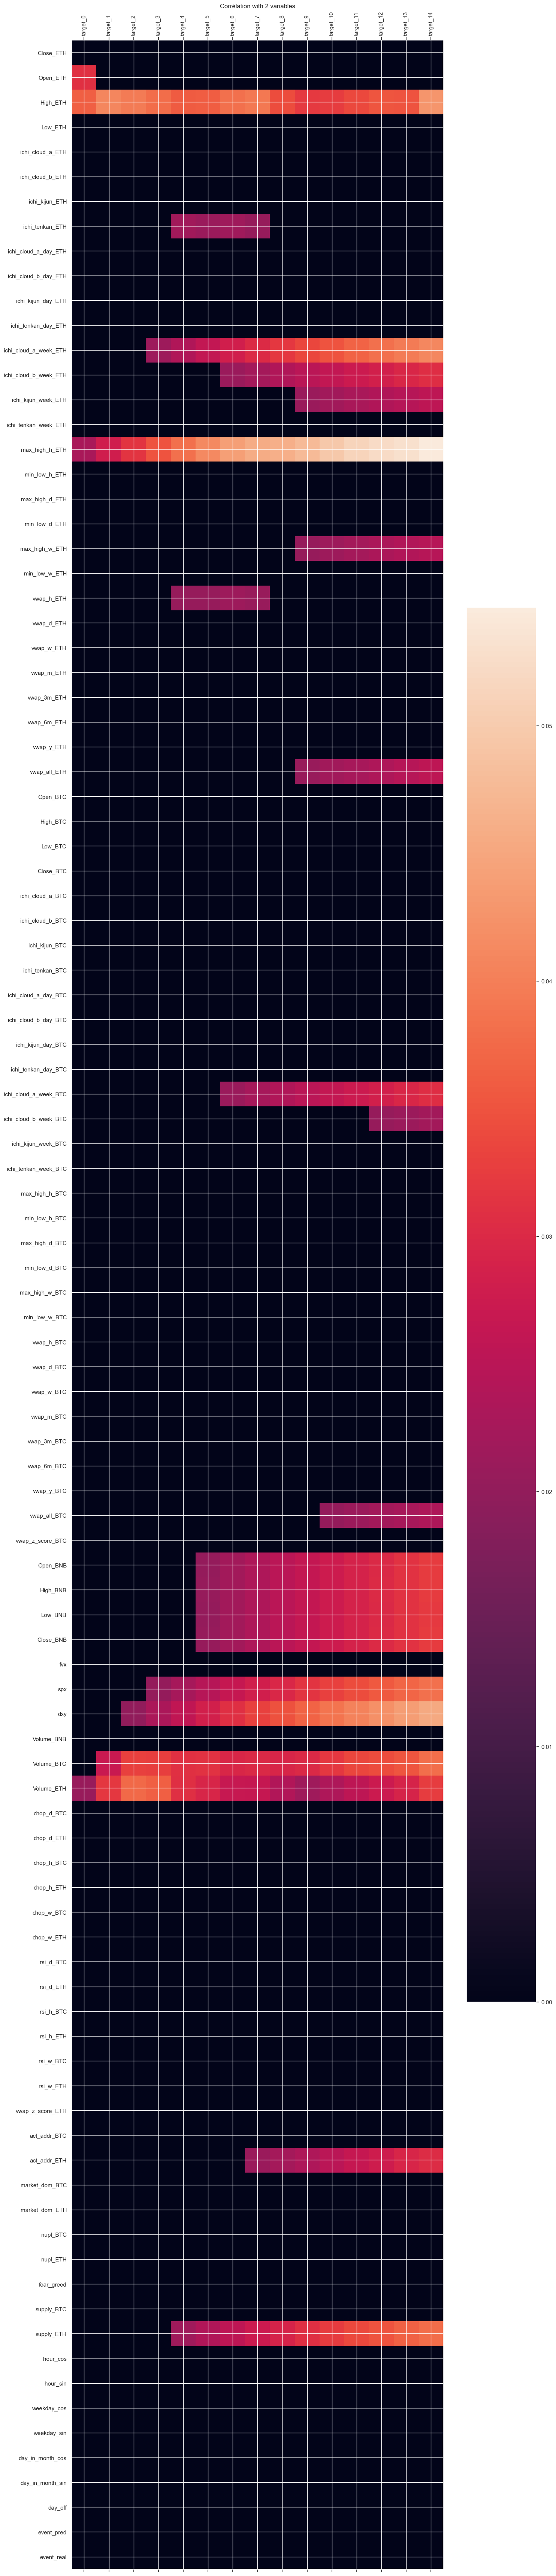

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

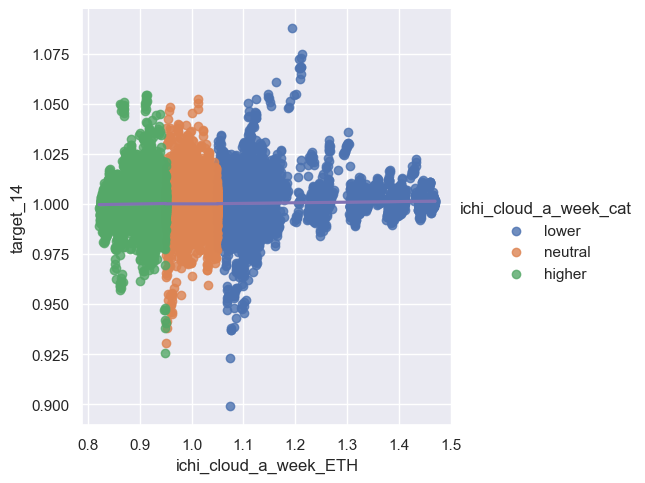

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

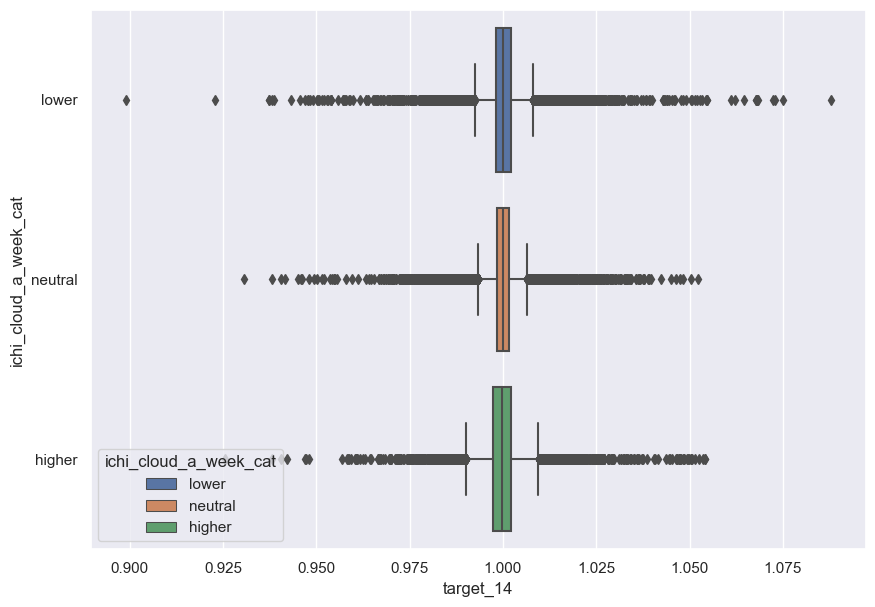

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


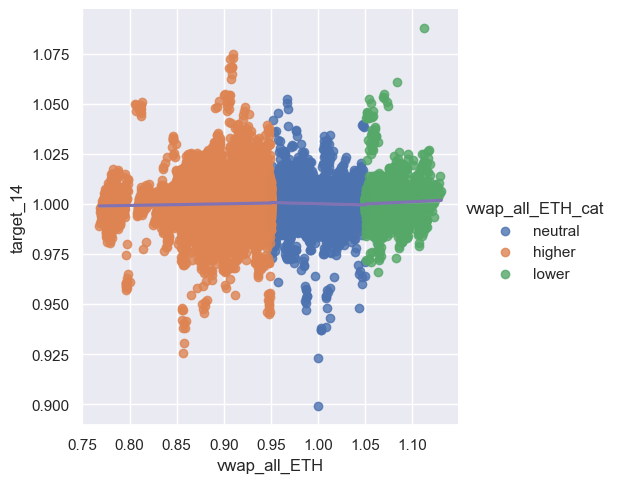

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

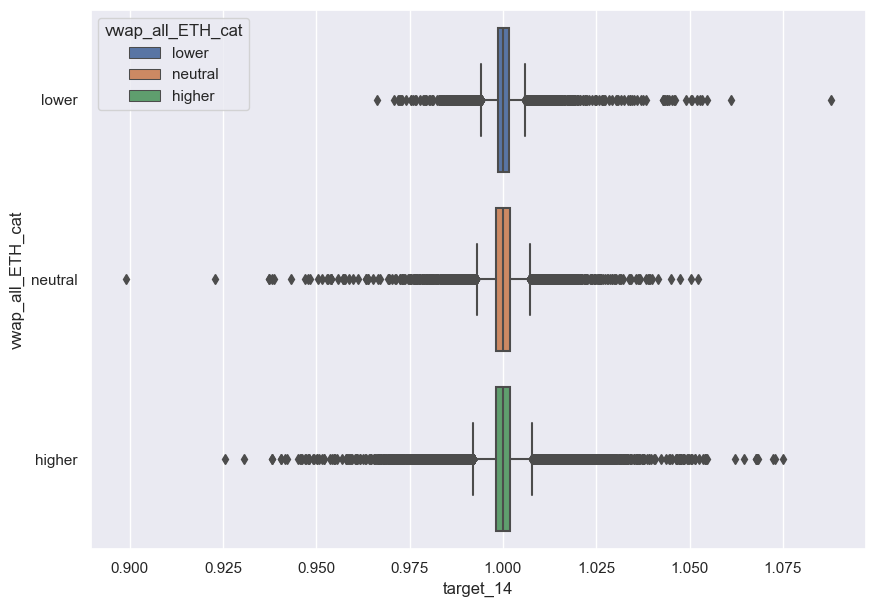

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

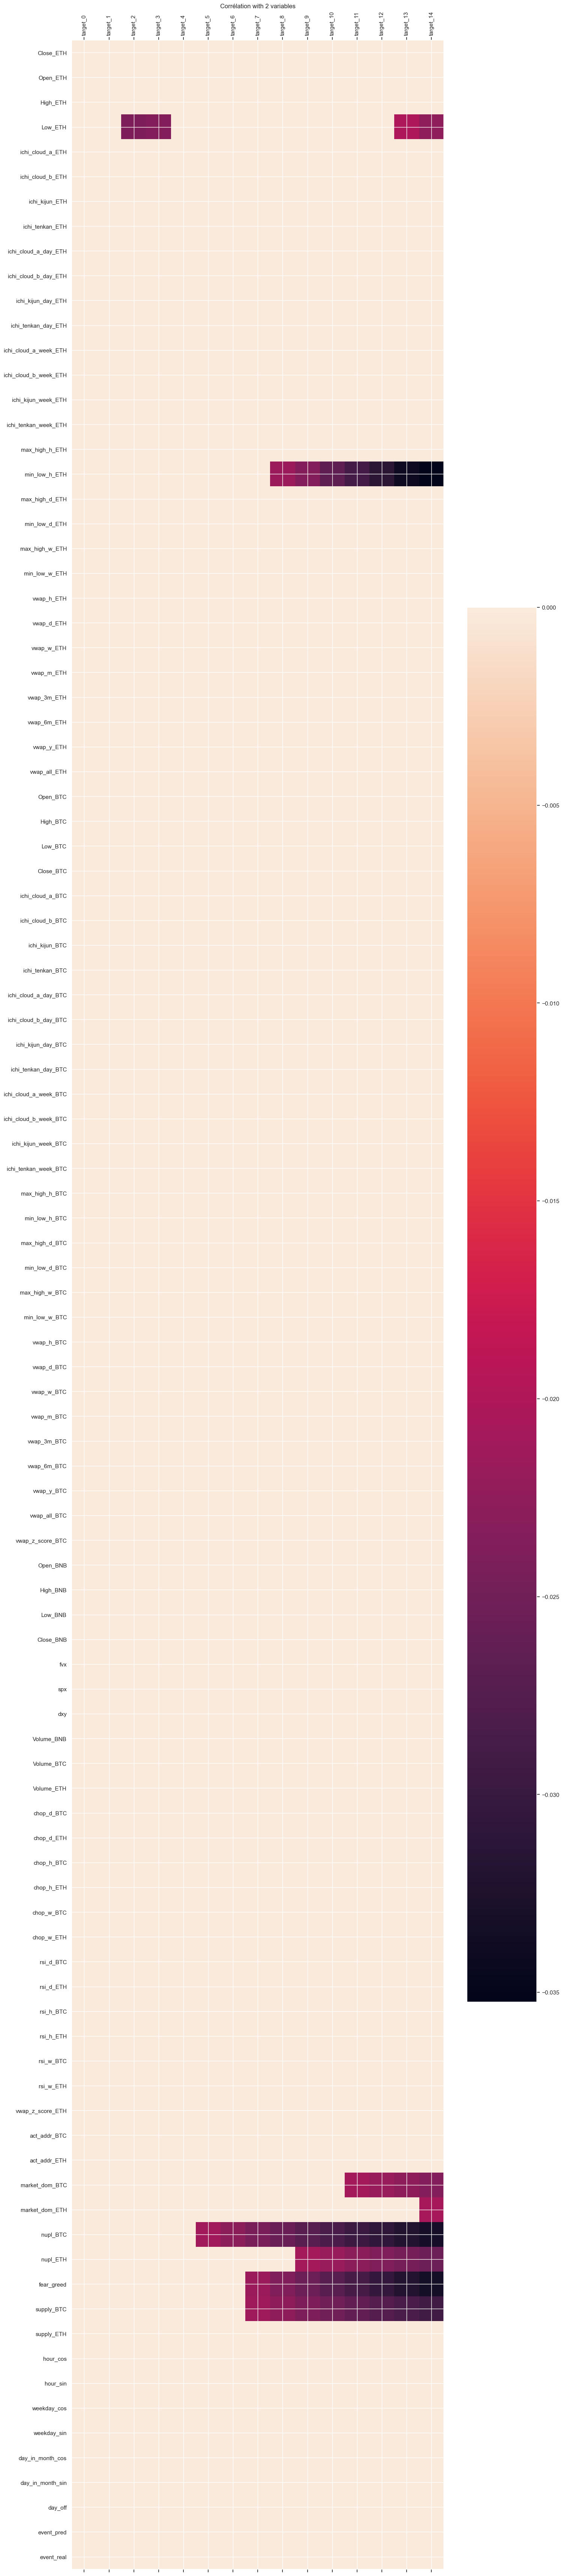

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

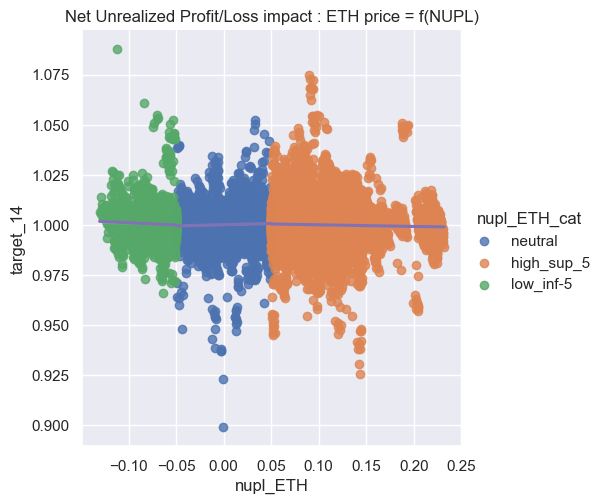

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

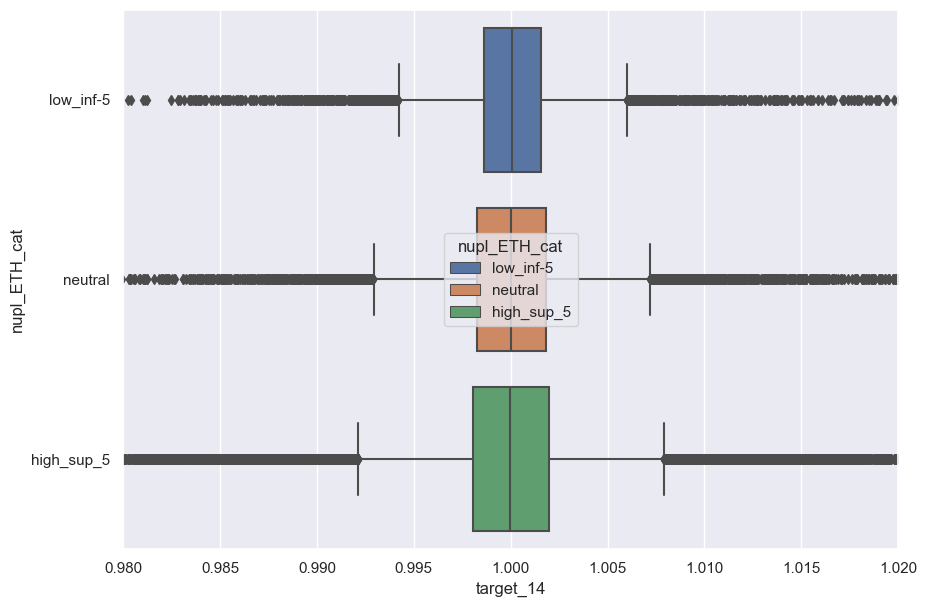

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    76846.000000
mean         1.000069
std          0.005461
min          0.899006
25%          0.998149
50%          1.000000
75%          1.001899
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    76846.000000
mean         1.000009
std          0.002026
min          0.907143
25%          0.999283
50%          1.000000
75%          1.000735
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

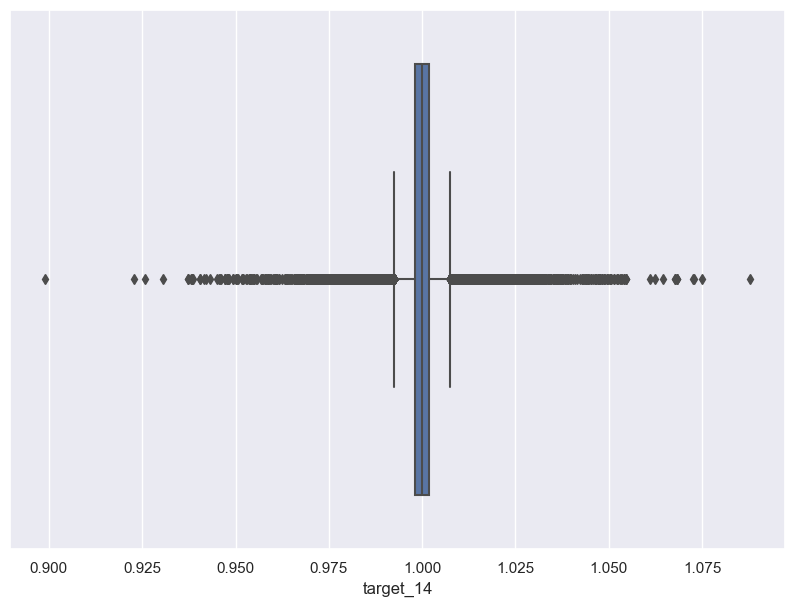

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99941266, 0.99864848, 0.99700013, ..., 0.99664014, 0.99698118,
        0.99661488],
       [0.99923537, 0.99758605, 0.99673927, ..., 0.99756709, 0.99720058,
        0.9976682 ],
       [0.99834942, 0.99750199, 0.99636366, ..., 0.99796365, 0.99843163,
        0.99931068]])

In [89]:
y_train_sca

array([[ 0.10571675,  0.08690585, -0.10329325, ..., -0.03641005,
         0.02838305, -0.04477045],
       [-0.02804099, -0.21815255, -0.05102151, ..., -0.08653686,
        -0.15965669, -0.30798549],
       [-0.19936463, -0.032221  , -0.15131084, ..., -0.14086436,
        -0.28920433, -0.36024037],
       ...,
       [-0.15588132, -0.34667434, -0.7582196 , ..., -0.84809731,
        -0.76295001, -0.85440451],
       [-0.20014389, -0.61193102, -0.82334664, ..., -0.61666421,
        -0.70817246, -0.59142055],
       [-0.42134098, -0.63291838, -0.91712681, ..., -0.51765607,
        -0.40081482, -0.18134275]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(76846, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

Training: TS 0.99 - units 128 - enc_dim 16 - drop 0.25 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         118272    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 16)          2064      
                                                                 
Total params: 120336 (470.06 KB)
Trainable params: 120336 (470.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 16)]        0         
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         74240     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 dense_1 (Dense)             (None, None, 102)         13158     
                                                                 
Total params: 87398 (341.40 KB)
Trainable params: 87398 (341.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/30
1201/1201 [==============================] - 55s 44ms/step - loss: 0.1737 - val_loss: 0.0425
Epoch 2/30
1201/1201 [=================

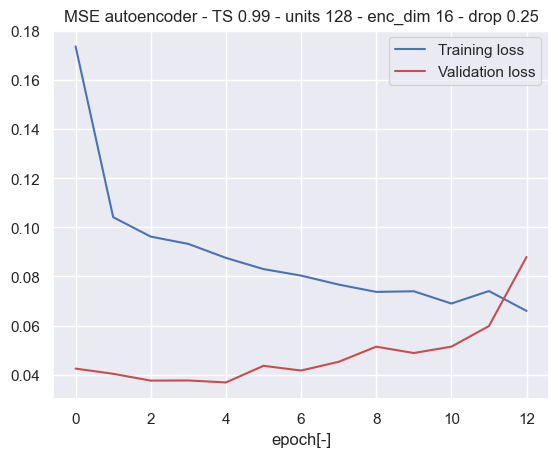

MSE TEST :  0.036822360008955
Save autoencoder:  data/mdl_autoencoder
INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


Save encoder:  data/mdl_encoder


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


Best model : n_unit:128 / enc_dim: 16 / dropout: 0.25


In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
seed = 1
epochs = 30 #100 #150 #6 #300
patience = 10 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [128]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [16]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                # check already done ? 
                #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                path_jpg = os.path.join(path_data,
                    f"output_MSE autoencoder - {plt_name}.jpg")
                if (MODE_TRAIN_AE == False):
                    print(f"BE CAREFUL ! training inactivated => no training done...")
                    continue
                print(f"Training: {plt_name} ...")
                # Init
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                # Input dimension
                input_dim = X_train.shape[-1]
                # Reduced encoded input dimension
                # 64/8/0.5
                # Définir l'encodeur
                encoder_inputs = keras.Input(shape=(None, input_dim))
                encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                #encoder = layers.LayerNormalization()(encoder)
                #encoder = layers.Dense(encoding_dim, activation='relu')
                encoder = layers.Dropout(dropout_autoenc)(encoder)
                encoder_outputs = layers.Dense(encoding_dim)(encoder)
                encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                print(encoder_model.summary())
                # Définir le décodeur
                decoder_inputs = keras.Input(shape=(None, encoding_dim))
                decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                #decoder = layers.LayerNormalization()(decoder)
                #decoder = layers.Dense(n_unit_enc, activation='relu')
                decoder = layers.Dropout(dropout_autoenc)(decoder)
                decoder_outputs = layers.Dense(input_dim)(decoder)
                decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                print(decoder_model.summary())
                # Define complete autoencoder 
                autoencoder_inputs = keras.Input(shape=(None, input_dim))
                encoded = encoder_model(autoencoder_inputs)
                decoded = decoder_model(encoded)
                autoencoder = keras.Model(autoencoder_inputs, decoded)
                # Compile : autoencoder
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                #optim = tf.keras.optimizers.Adam()
                autoencoder.compile(optimizer=optim, loss="mse")
                # earlystop 
                es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                monitor='val_loss', mode='auto', restore_best_weights=True)
                # Train
                if patience == 0:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1)
                else:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1, callbacks=[es])

                plot_train_history(
                    autoenc_step_history,f"MSE autoencoder - {plt_name}",
                    saveFolder=path_data)
                #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                            # save the best
                mse_curr = np.min(autoenc_step_history.history['val_loss'])
                print("MSE TEST : ", mse_curr)

                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_unit_enc_min = n_unit_enc
                    encoding_dim_min = encoding_dim
                    dropout_autoenc_min = dropout_autoenc
                    print("Save autoencoder: ", path_mdl_autoencoder)
                    autoencoder.save(path_mdl_autoencoder)
                    print("Save encoder: ", path_mdl_encoder)
                    encoder_model.save(path_mdl_encoder)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())
    n_unit_enc = encoder_model.layers[1].units
    dropout_autoenc = encoder_model.layers[2].rate
    encoding_dim = encoder_model.layers[3].units

print(f"Best model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

### Save model

In [95]:
# TODO select best model


In [96]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [97]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [98]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2402/2402 [==============================] - 54s 22ms/step


(76846, 72, 102)

### Results

In [99]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

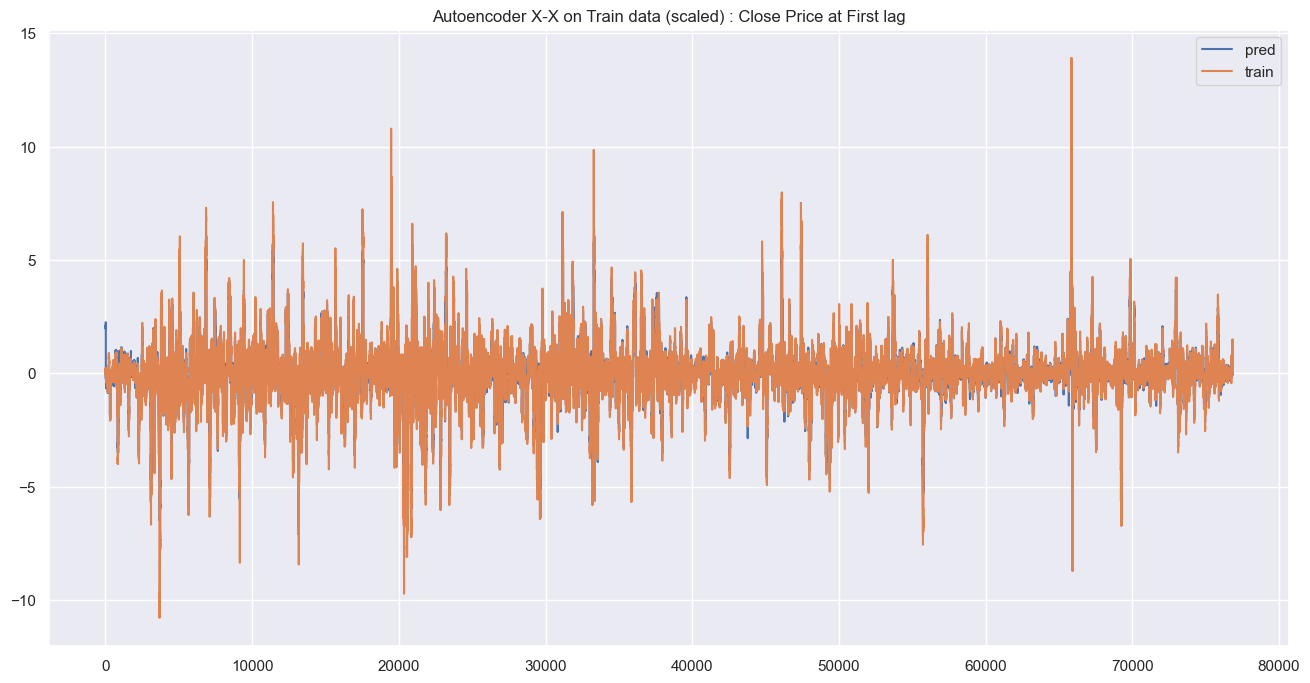

In [100]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [101]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(76846, 72, 102)
(76846, 72, 102)
(72, 102)
(1, 102)


In [102]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.144374  0.149801  0.140595  0.143900          0.261429   
lag_1    0.117965  0.113490  0.109195  0.112546          0.232758   
lag_2    0.111114  0.106321  0.100242  0.104858          0.212055   
lag_3    0.106072  0.100849  0.094069  0.099685          0.200393   
lag_4    0.103177  0.097469  0.090348  0.096729          0.190502   
...           ...       ...       ...       ...               ...   
lag_67   0.083378  0.085505  0.071272  0.079769          0.135357   
lag_68   0.082872  0.085171  0.070782  0.079321          0.135270   
lag_69   0.082369  0.084819  0.070313  0.078860          0.135180   
lag_70   0.081871  0.084424  0.069827  0.078404          0.135101   
lag_71   0.081287  0.084202  0.069303  0.077905          0.135019   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.292274        0.167473         0.161834   
lag_1           0.262395        0.138130         0.128880   
lag_2           0.239957        0.126745         0.116681   
lag_3           0.227333        0.121477         0.107941   
lag_4           0.216633        0.117669         0.100429   
...                  ...             ...              ...   
lag_67          0.147428        0.100616         0.075867   
lag_68          0.147413        0.100461         0.075602   
lag_69          0.147376        0.100289         0.075372   
lag_70          0.147348        0.100158         0.075154   
lag_71          0.147316        0.099995         0.074906   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.254195              0.228805  ...    0.289047  0.564062   
lag_1               0.207600              0.180069  ...    0.231469  0.346907   
lag_2               0.184016              0.154654  ...    0.196557  0.276053   
lag_3               0.169869              0.139140  ...    0.173428  0.233308   
lag_4               0.159928              0.127890  ...    0.155219  0.207779   
...                      ...                   ...  ...         ...       ...   
lag_67              0.112548              0.094463  ...    0.081206  0.131596   
lag_68              0.112537              0.094416  ...    0.081180  0.131495   
lag_69              0.112539              0.094391  ...    0.081139  0.131368   
lag_70              0.112529              0.094338  ...    0.081111  0.131277   
lag_71              0.112520              0.094286  ...    0.081077  0.131183   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.543030     0.506702     0.505001          0.478534   
lag_1   0.352122     0.313402     0.318024          0.292498   
lag_2   0.288396     0.253411     0.267305          0.240102   
lag_3   0.253525     0.218490     0.236504          0.209476   
lag_4   0.232448     0.197361     0.214689          0.188742   
...          ...          ...          ...               ...   
lag_67  0.149747     0.141857     0.137287          0.129804   
lag_68  0.149634     0.141792     0.137231          0.129774   
lag_69  0.149539     0.141710     0.137143          0.129729   
lag_70  0.149452     0.141638     0.137042          0.129675   
lag_71  0.149331     0.141546     0.136977          0.129600   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.513488  0.312145    0.119505    0.107159  
lag_1           0.342944  0.236172    0.112355    0.093875  
lag_2           0.274920  0.141102    0.091162    0.073998  
lag_3           0.232526  0.097179    0.076470    0.065089  
lag_4           0.203963  0.081265    0.066874    0.060196  
...                  ...       ...         ...         ...  
lag_67          0.120201  0.052072    0.051730    0.052835  
lag_68          0.120149  0.052021    0.051711    0.052819  
lag_69          0.120107  0.051957    0.051691    0.052808  
lag_70          0.120062  0.051897    0.051666    0.052788  
lag_71          0.120009  0.05180

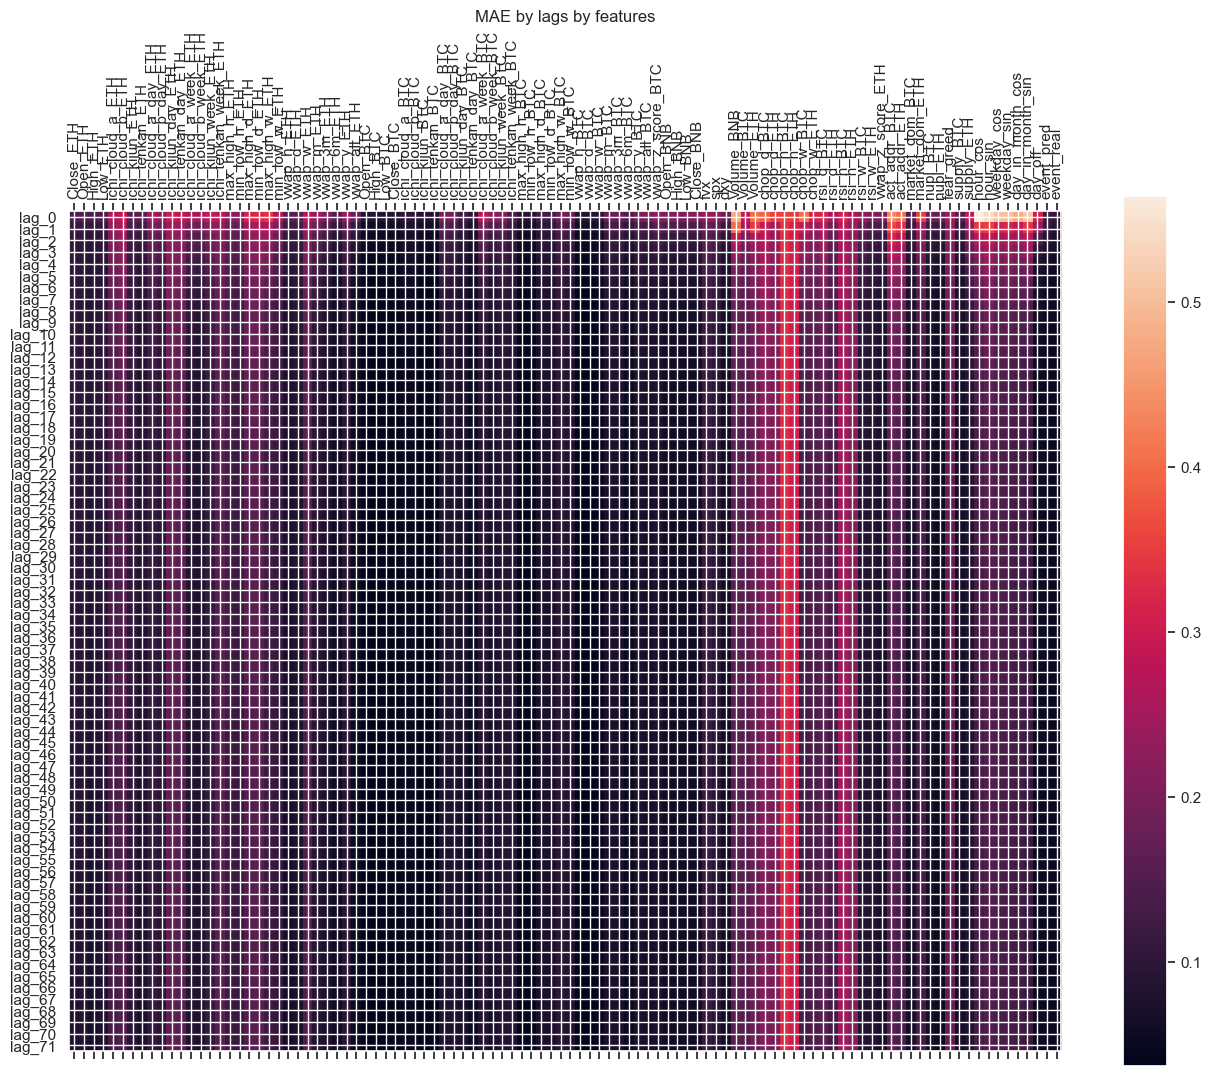

In [103]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

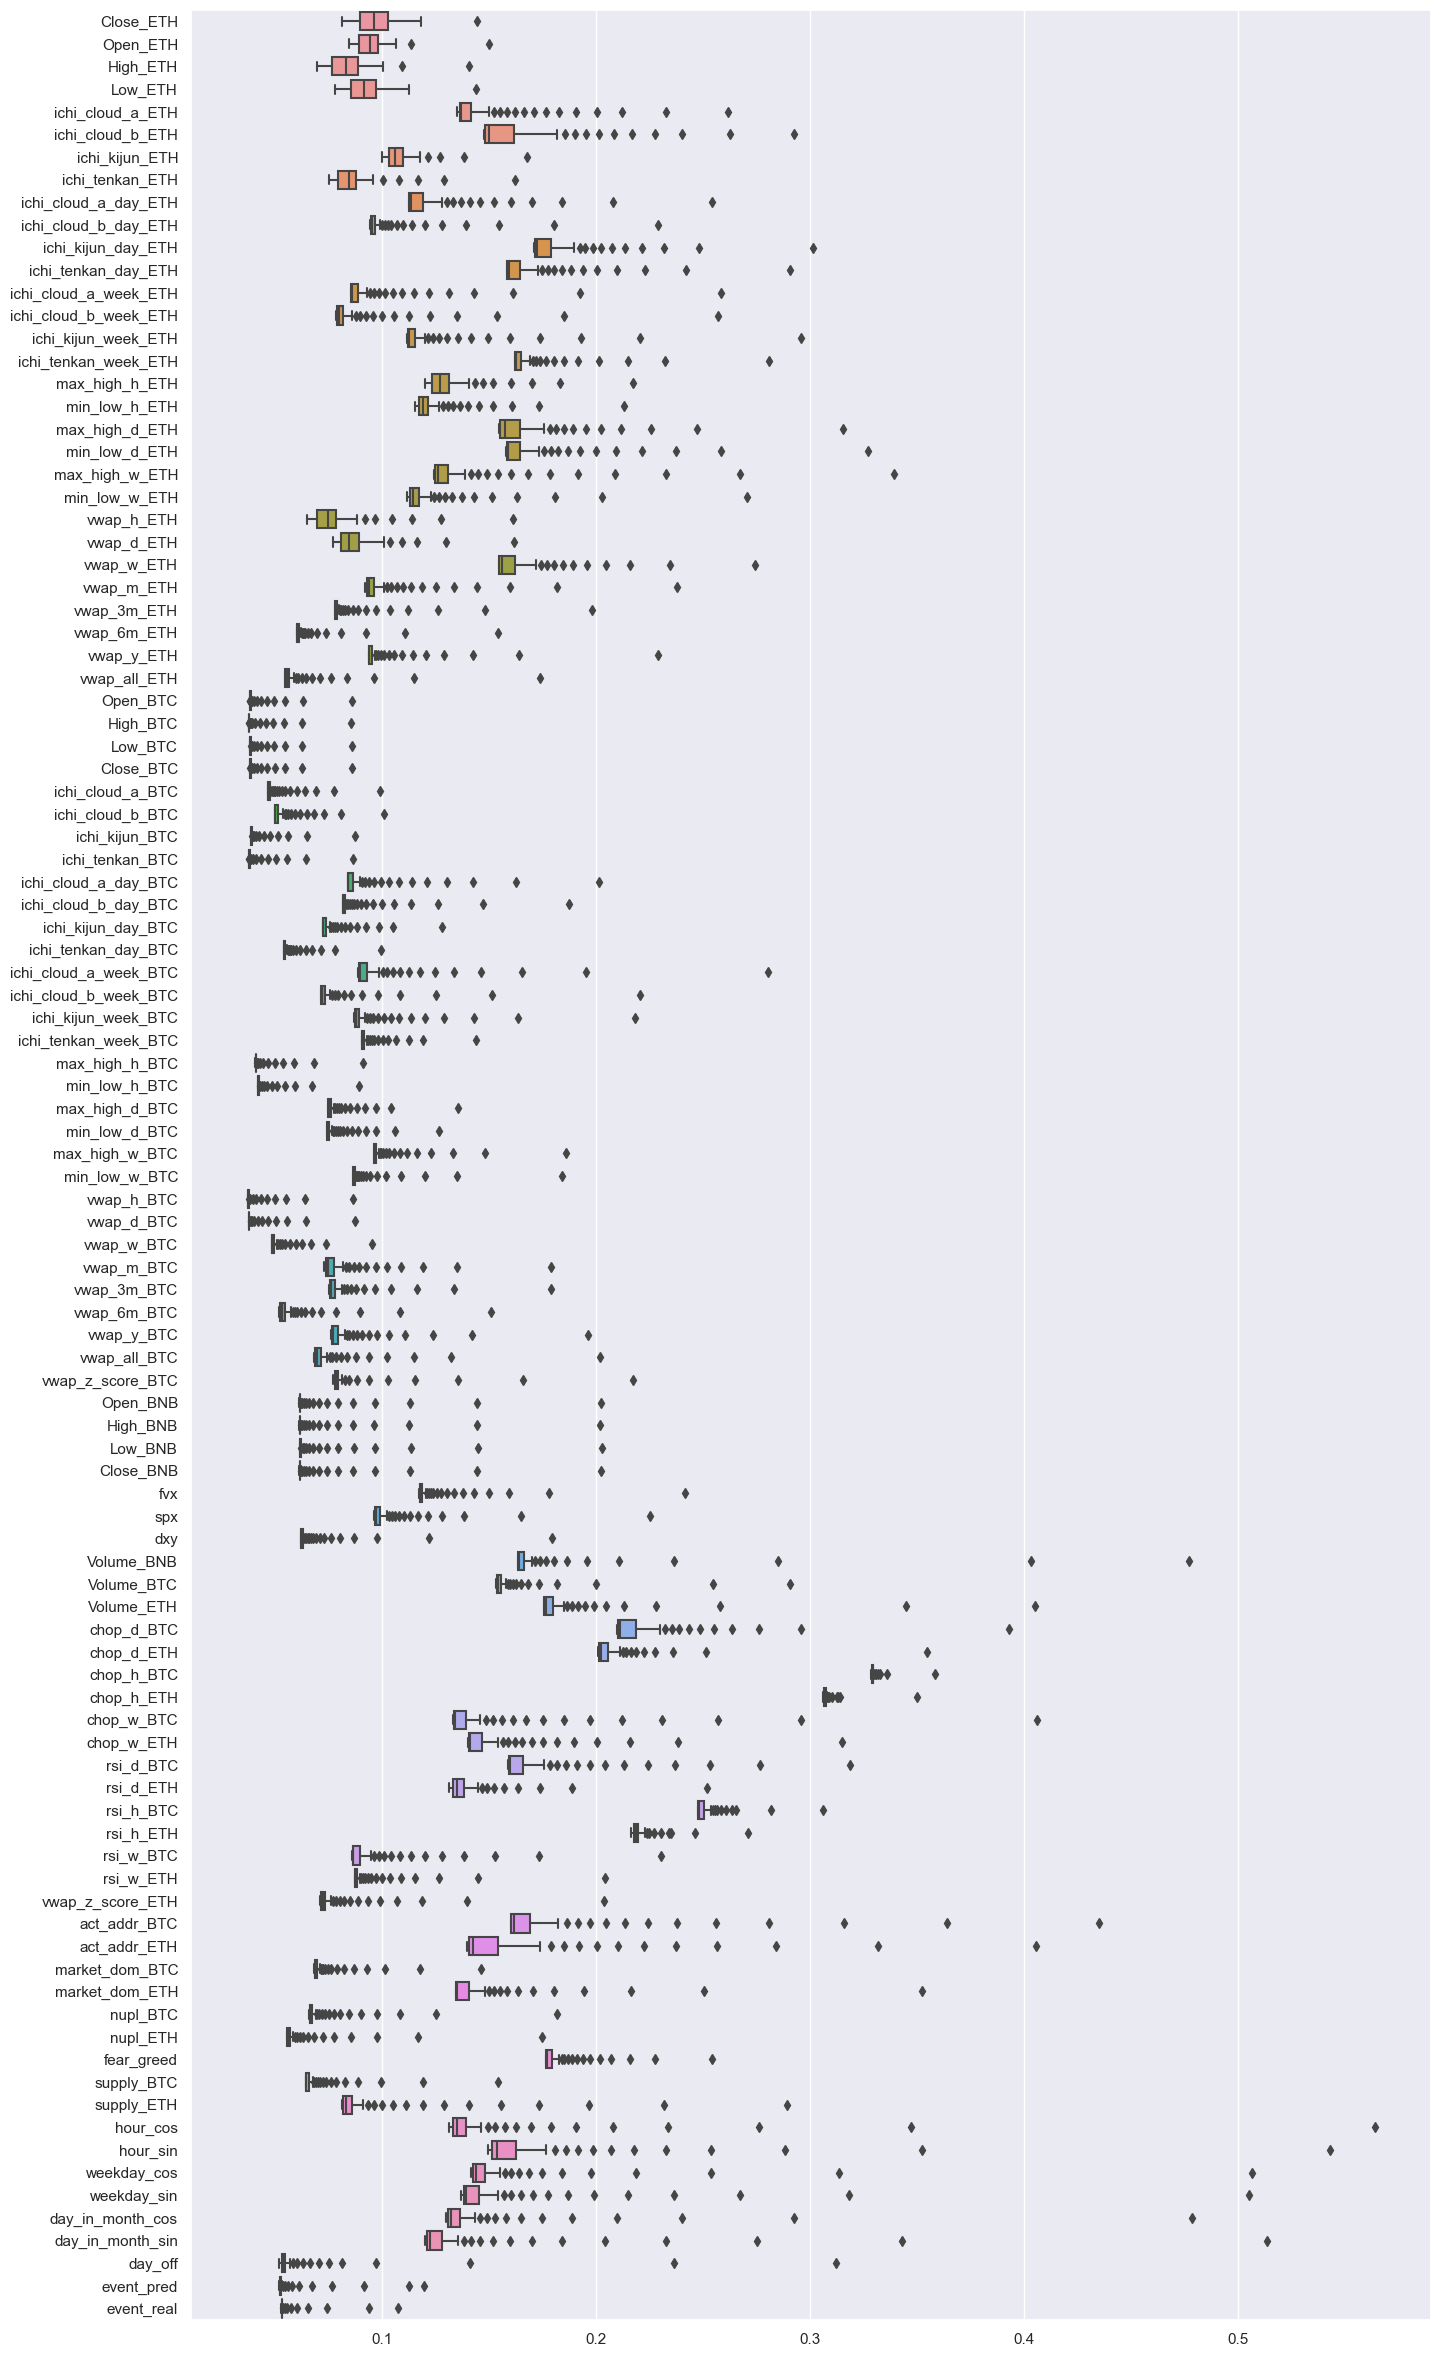

In [104]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [105]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.096148   0.09437  0.083186  0.091507          0.146237   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0           0.16227        0.107978         0.085871              0.122368   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.101591  ...    0.094908  0.151199  0.170862     0.157052   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.154959          0.145085          0.139451  0.062846    0.055339   

   event_real  
0    0.054949  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

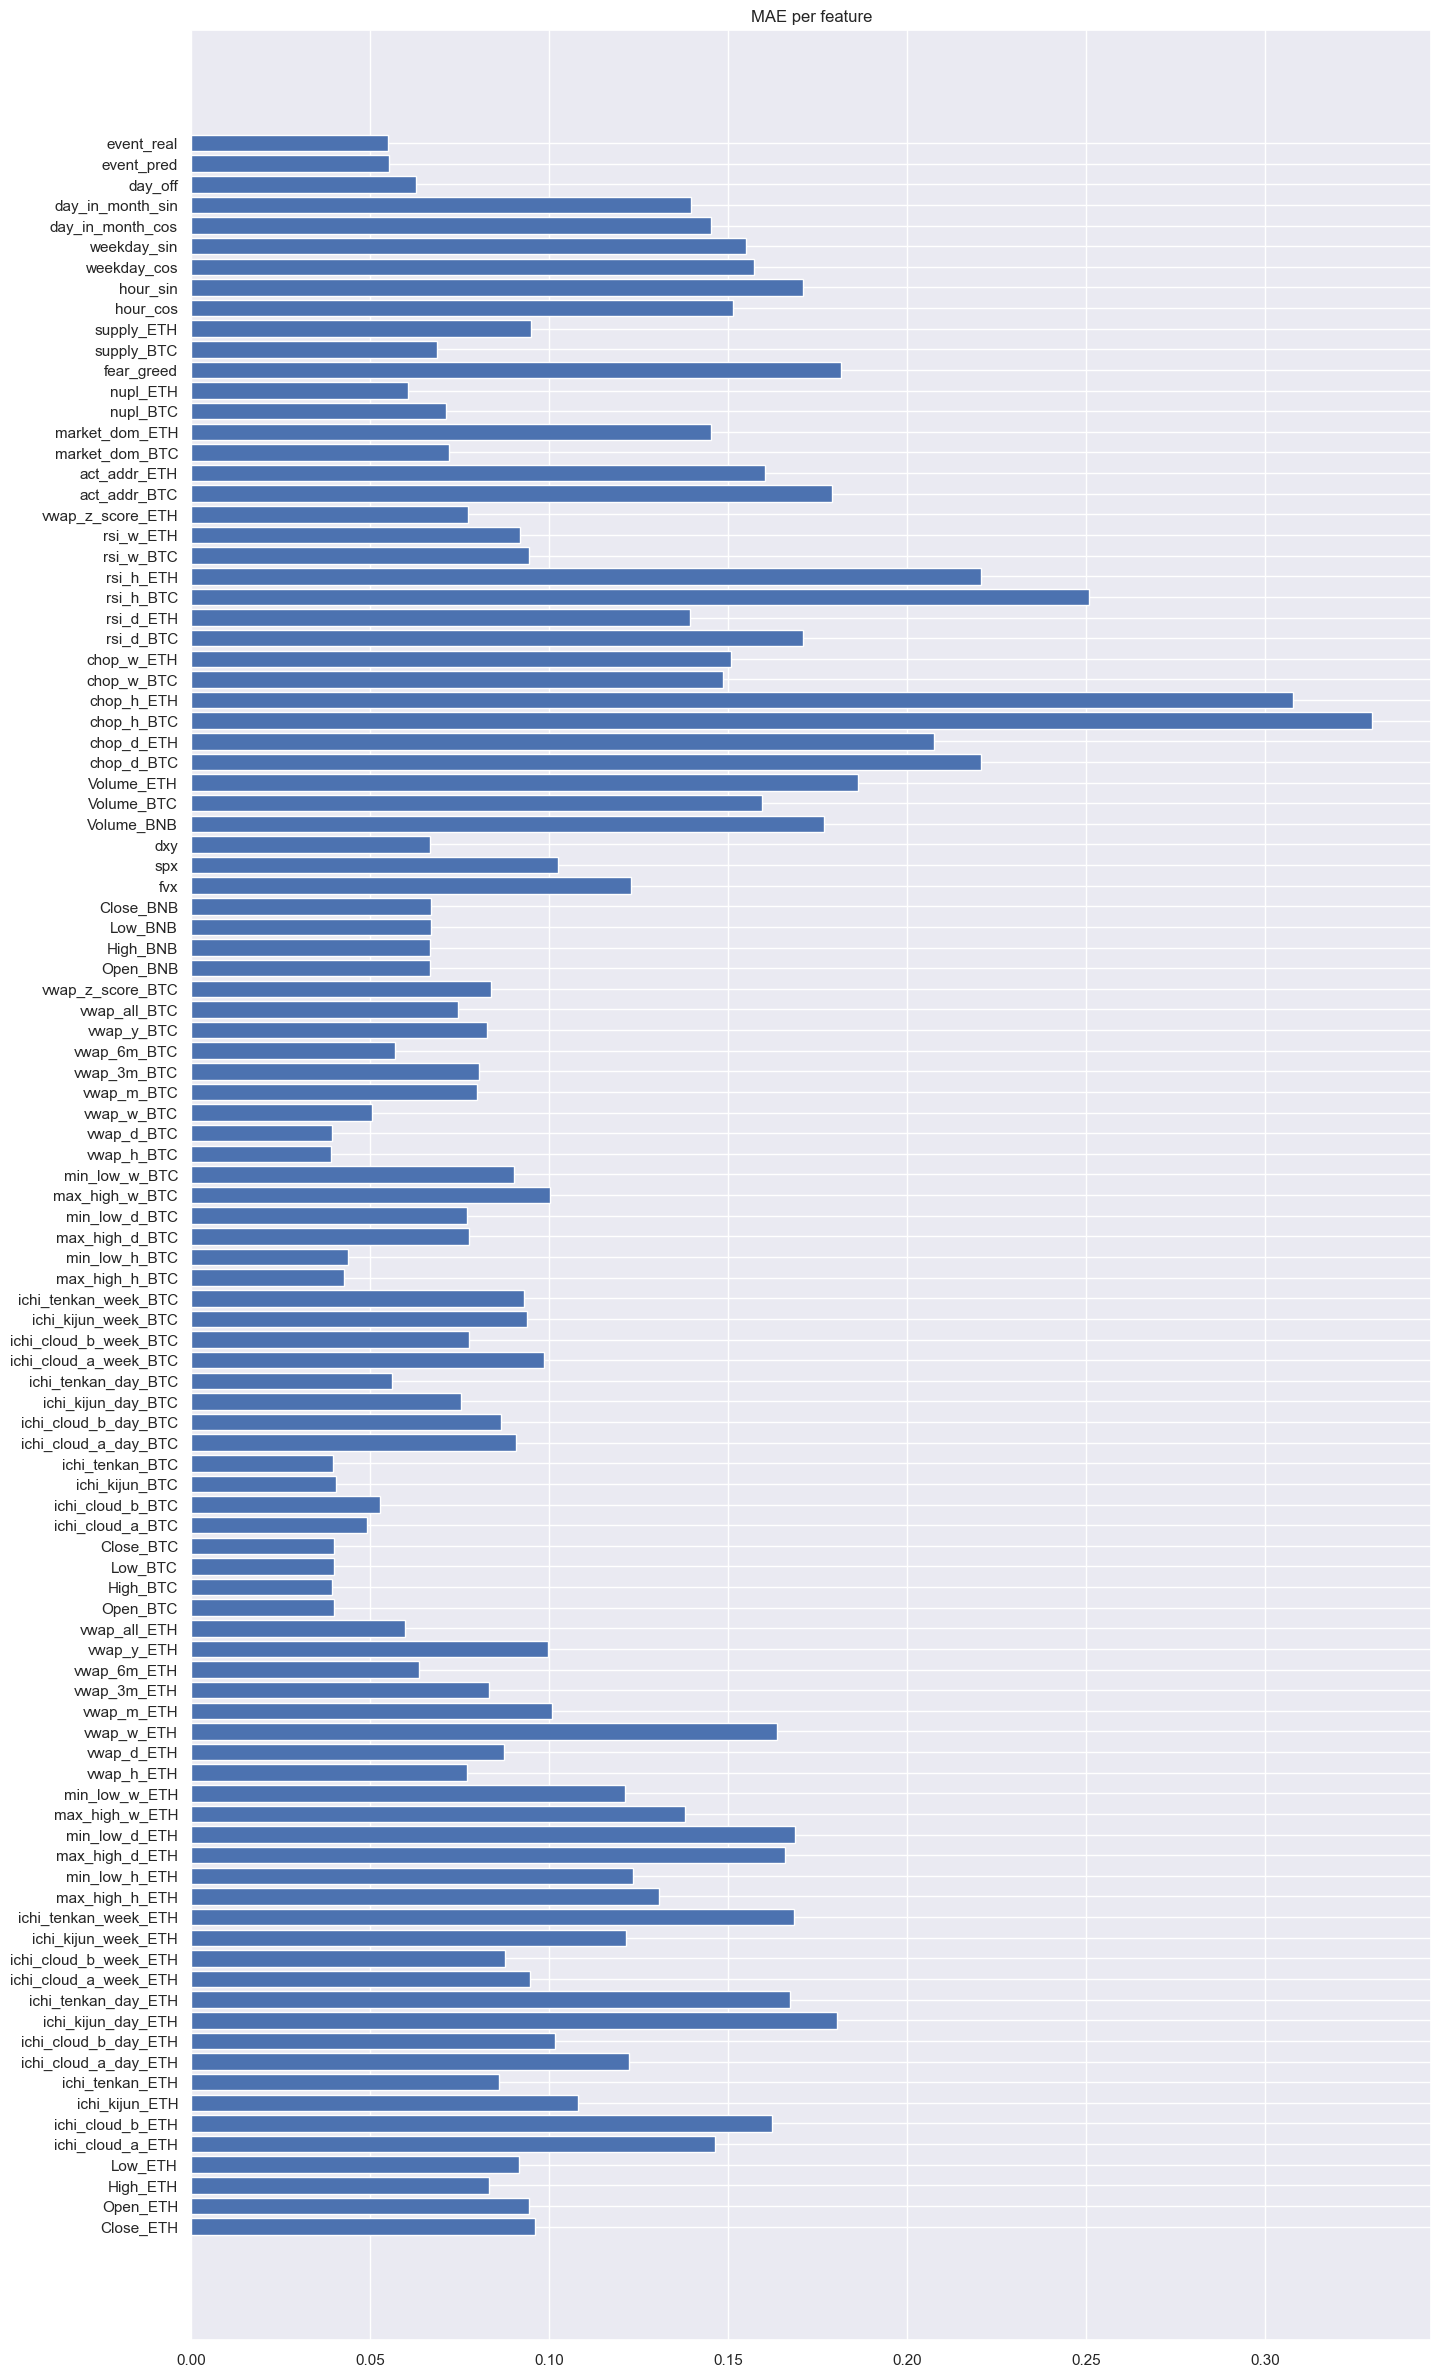

In [106]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [107]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(76846,)
(76846,)
[1196.32 1195.38 1194.55 ... 1586.18 1585.91 1586.01]
[1196.32 1195.38 1194.55]


In [108]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9985799 , 0.9986284 , 0.99923354, ..., 0.99847734, 0.9988534 ,
       0.99901515], dtype=float32)

[1196.32 1195.38 1194.55 ... 1586.18 1585.91 1586.01]
[1214.46023063 1214.88106815 1214.73074377 ... 1585.3334276  1584.27382468
 1584.46055646]


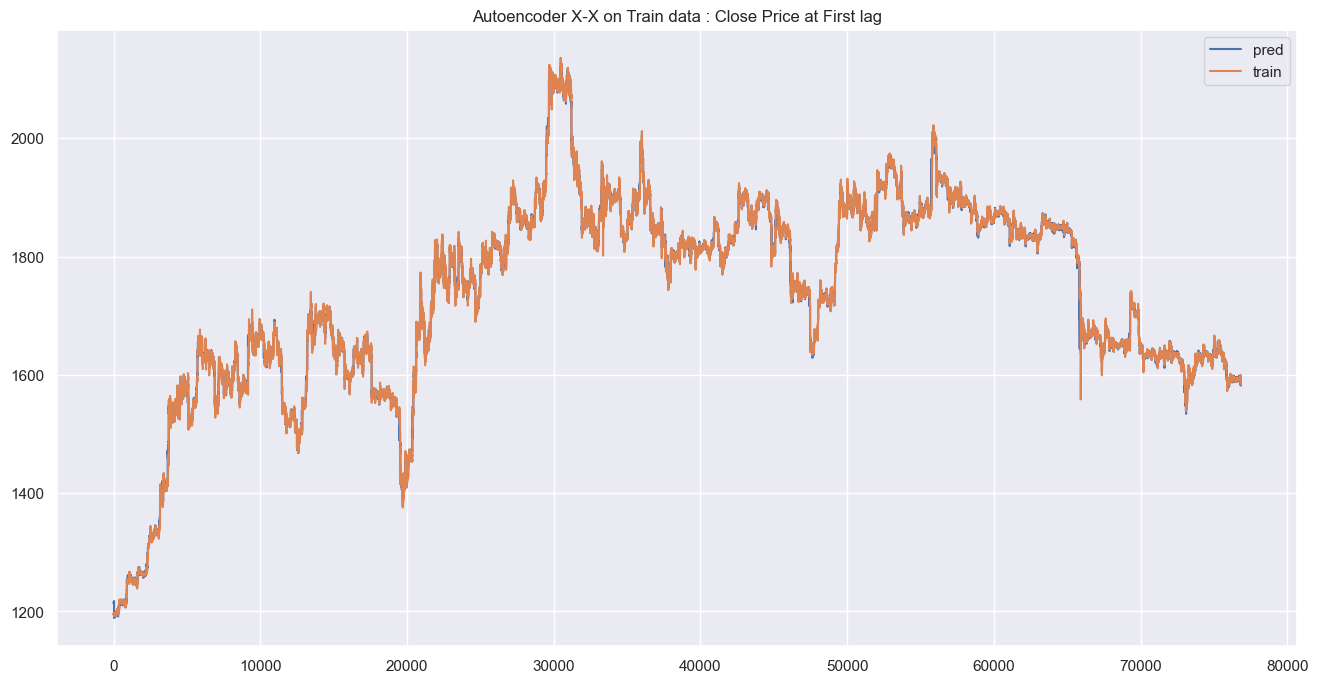

In [109]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [110]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

22/22 [==============================] - 1s 32ms/step


(689, 72, 102)

In [111]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-09-25 03:00:00'

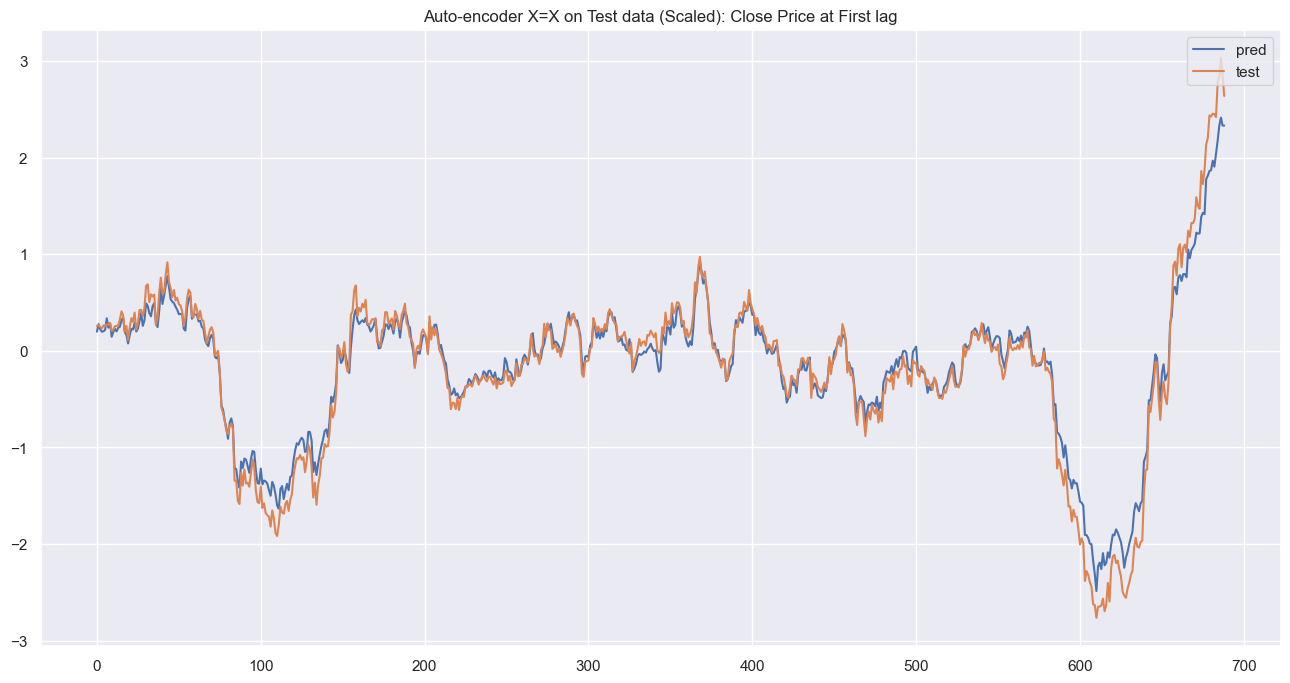

In [112]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [113]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1581.61 1581.24 1580.72 1580.18 1579.56 1580.51 1579.59 1579.11 1577.75]
X test pred :  [1580.84110086 1581.38915543 1580.44435202 1579.73162639 1578.75789284
 1579.9070672  1580.44276217 1578.71768239 1577.74325093]


[1581.61 1581.24 1580.72 1580.18 1579.56 1580.51 1579.59 1579.11 1577.75
 1578.48 1577.72 1576.53 1577.01 1577.27 1578.54 1579.34 1579.34 1578.13
 1578.09 1577.39 1577.28 1578.4  1578.69 1579.39 1578.24 1578.04 1578.11
 1576.42 1575.74 1575.71 1575.81 1576.01 1574.48 1575.29 1576.37 1576.5
 1573.6  1573.3  1574.59 1575.98 1576.7  1578.53 1578.84 1580.46 1579.33
 1579.7  1578.57 1579.02 1578.04 1578.91 1578.68 1579.37 1578.69 1577.38
 1577.6  1580.11 1581.05 1581.83 1581.25 1581.11 1581.58 1581.03 1579.76
 1579.6  1579.1  1578.52 1577.9  1576.52 1577.56 1578.29 1578.39 1578.38
 1577.88 1577.65 1577.27 1576.24 1577.2  1576.15 1575.71 1574.11 1575.92
 1575.   1573.33 1573.77 1573.97 1574.42 1574.1  1574.67 1575.66 1574.85
 1576.05 1574.27 1574.1  1574.9  1574.32 1575.5  1574.45 1572.69 1571.
 1571.19 1570.05 1567.14 1567.13 1568.01 1567.77 1569.13 1569.01 1570.25
 1568.94 1566.85 1566.19 1569.08 1570.71 1568.56 1568.57 1570.13 1571.32
 1571.41 1570.88 1571.34 1571.83 1572.49 1573.33 1573.

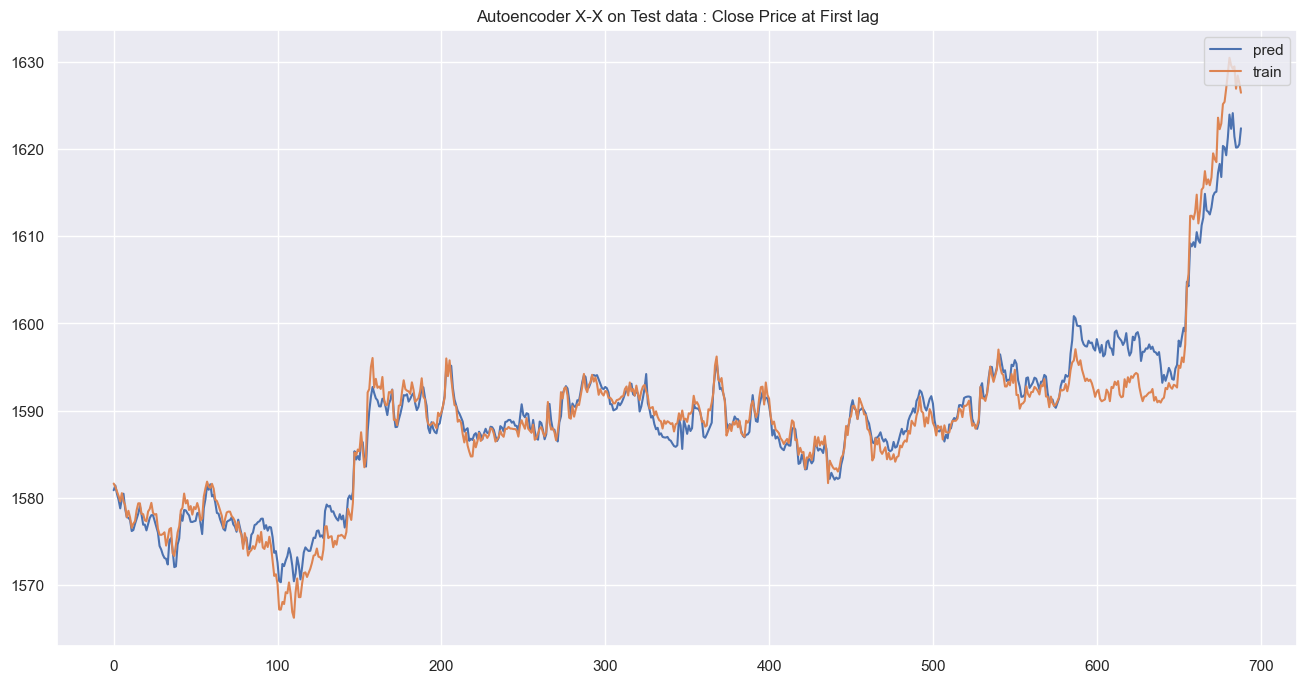

In [114]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [115]:
X_test_sca.shape

(689, 72, 102)

In [116]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.2208523743670797

In [117]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(689, 72, 102)
(689, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.144374  0.149801  0.140595  0.143900          0.261429   
lag_1    0.117965  0.113490  0.109195  0.112546          0.232758   
lag_2    0.111114  0.106321  0.100242  0.104858          0.212055   
lag_3    0.106072  0.100849  0.094069  0.099685          0.200393   
lag_4    0.103177  0.097469  0.090348  0.096729          0.190502   
...           ...       ...       ...       ...               ...   
lag_67   0.063636  0.065797  0.049672  0.063801          0.119879   
lag_68   0.063649  0.065641  0.049520  0.063501          0.119410   
lag_69   0.063028  0.065578  0.049153  0.063440          0.118925   
lag_70   0.062930  0.065524  0.049076  0.063240          0.118603   
lag_71   0.062624  0.066035  0.049243  0.063203          0.118109   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.292274        0.167473         0.161834   
lag_1           0.262395        0.138130         0.128880   
lag_2           0.239957        0.126745         0.116681   
lag_3           0.227333        0.121477         0.107941   
lag_4           0.216633        0.117669         0.100429   
...                  ...             ...              ...   
lag_67          0.108942        0.090853         0.062429   
lag_68          0.109524        0.090865         0.061977   
lag_69          0.109958        0.090688         0.061488   
lag_70          0.110346        0.090603         0.061325   
lag_71          0.110676        0.090507         0.061386   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.254195              0.228805  ...  0.564062  0.543030   
lag_1               0.207600              0.180069  ...  0.346907  0.352122   
lag_2               0.184016              0.154654  ...  0.276053  0.288396   
lag_3               0.169869              0.139140  ...  0.233308  0.253525   
lag_4               0.159928              0.127890  ...  0.207779  0.232448   
...                      ...                   ...  ...       ...       ...   
lag_67              0.211741              0.089173  ...  0.123417  0.140333   
lag_68              0.211715              0.089462  ...  0.123332  0.140385   
lag_69              0.211674              0.089656  ...  0.123025  0.140335   
lag_70              0.211581              0.089793  ...  0.122675  0.140280   
lag_71              0.211549              0.089966  ...  0.122465  0.140299   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.506702     0.505001          0.478534          0.513488   
lag_1      0.313402     0.318024          0.292498          0.342944   
lag_2      0.253411     0.267305          0.240102          0.274920   
lag_3      0.218490     0.236504          0.209476          0.232526   
lag_4      0.197361     0.214689          0.188742          0.203963   
...             ...          ...               ...               ...   
lag_67     0.208977     0.120361          0.553465          0.093960   
lag_68     0.208162     0.120396          0.553806          0.093760   
lag_69     0.207373     0.120285          0.554220          0.093618   
lag_70     0.206492     0.120426          0.554593          0.093460   
lag_71     0.205687     0.120451          0.555122          0.093103   

         day_off  event_pred  event_real  dataset  
lag_0   0.312145    0.119505    0.107159    TRAIN  
lag_1   0.236172    0.112355    0.093875    TRAIN  
lag_2   0.141102    0.091162    0.073998    TRAIN  
lag_3   0.097179    0.076470    0.065089    TRAIN  
lag_4   0.081265    0.066874    0.060196    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.039791    0.049469    0.077472     TEST  
lag_68  0.039649    0.049641    0.077493     TEST  
lag_69  0.039561    0.049675    0.077424     TEST  
lag_70  0.039512    0.049674    0.077398     TEST  
lag_71  0.039424    0.049643    0.077362     TEST  

[144 ro

In [118]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.077244  0.075967  0.064581  0.077154          0.116328   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0           0.11518        0.094423         0.075942              0.213187   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0               0.08311  ...    0.067008  0.143934  0.163479     0.252757   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.132902           0.54681          0.119392  0.051627    0.053191   

   event_real  
0    0.082246  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

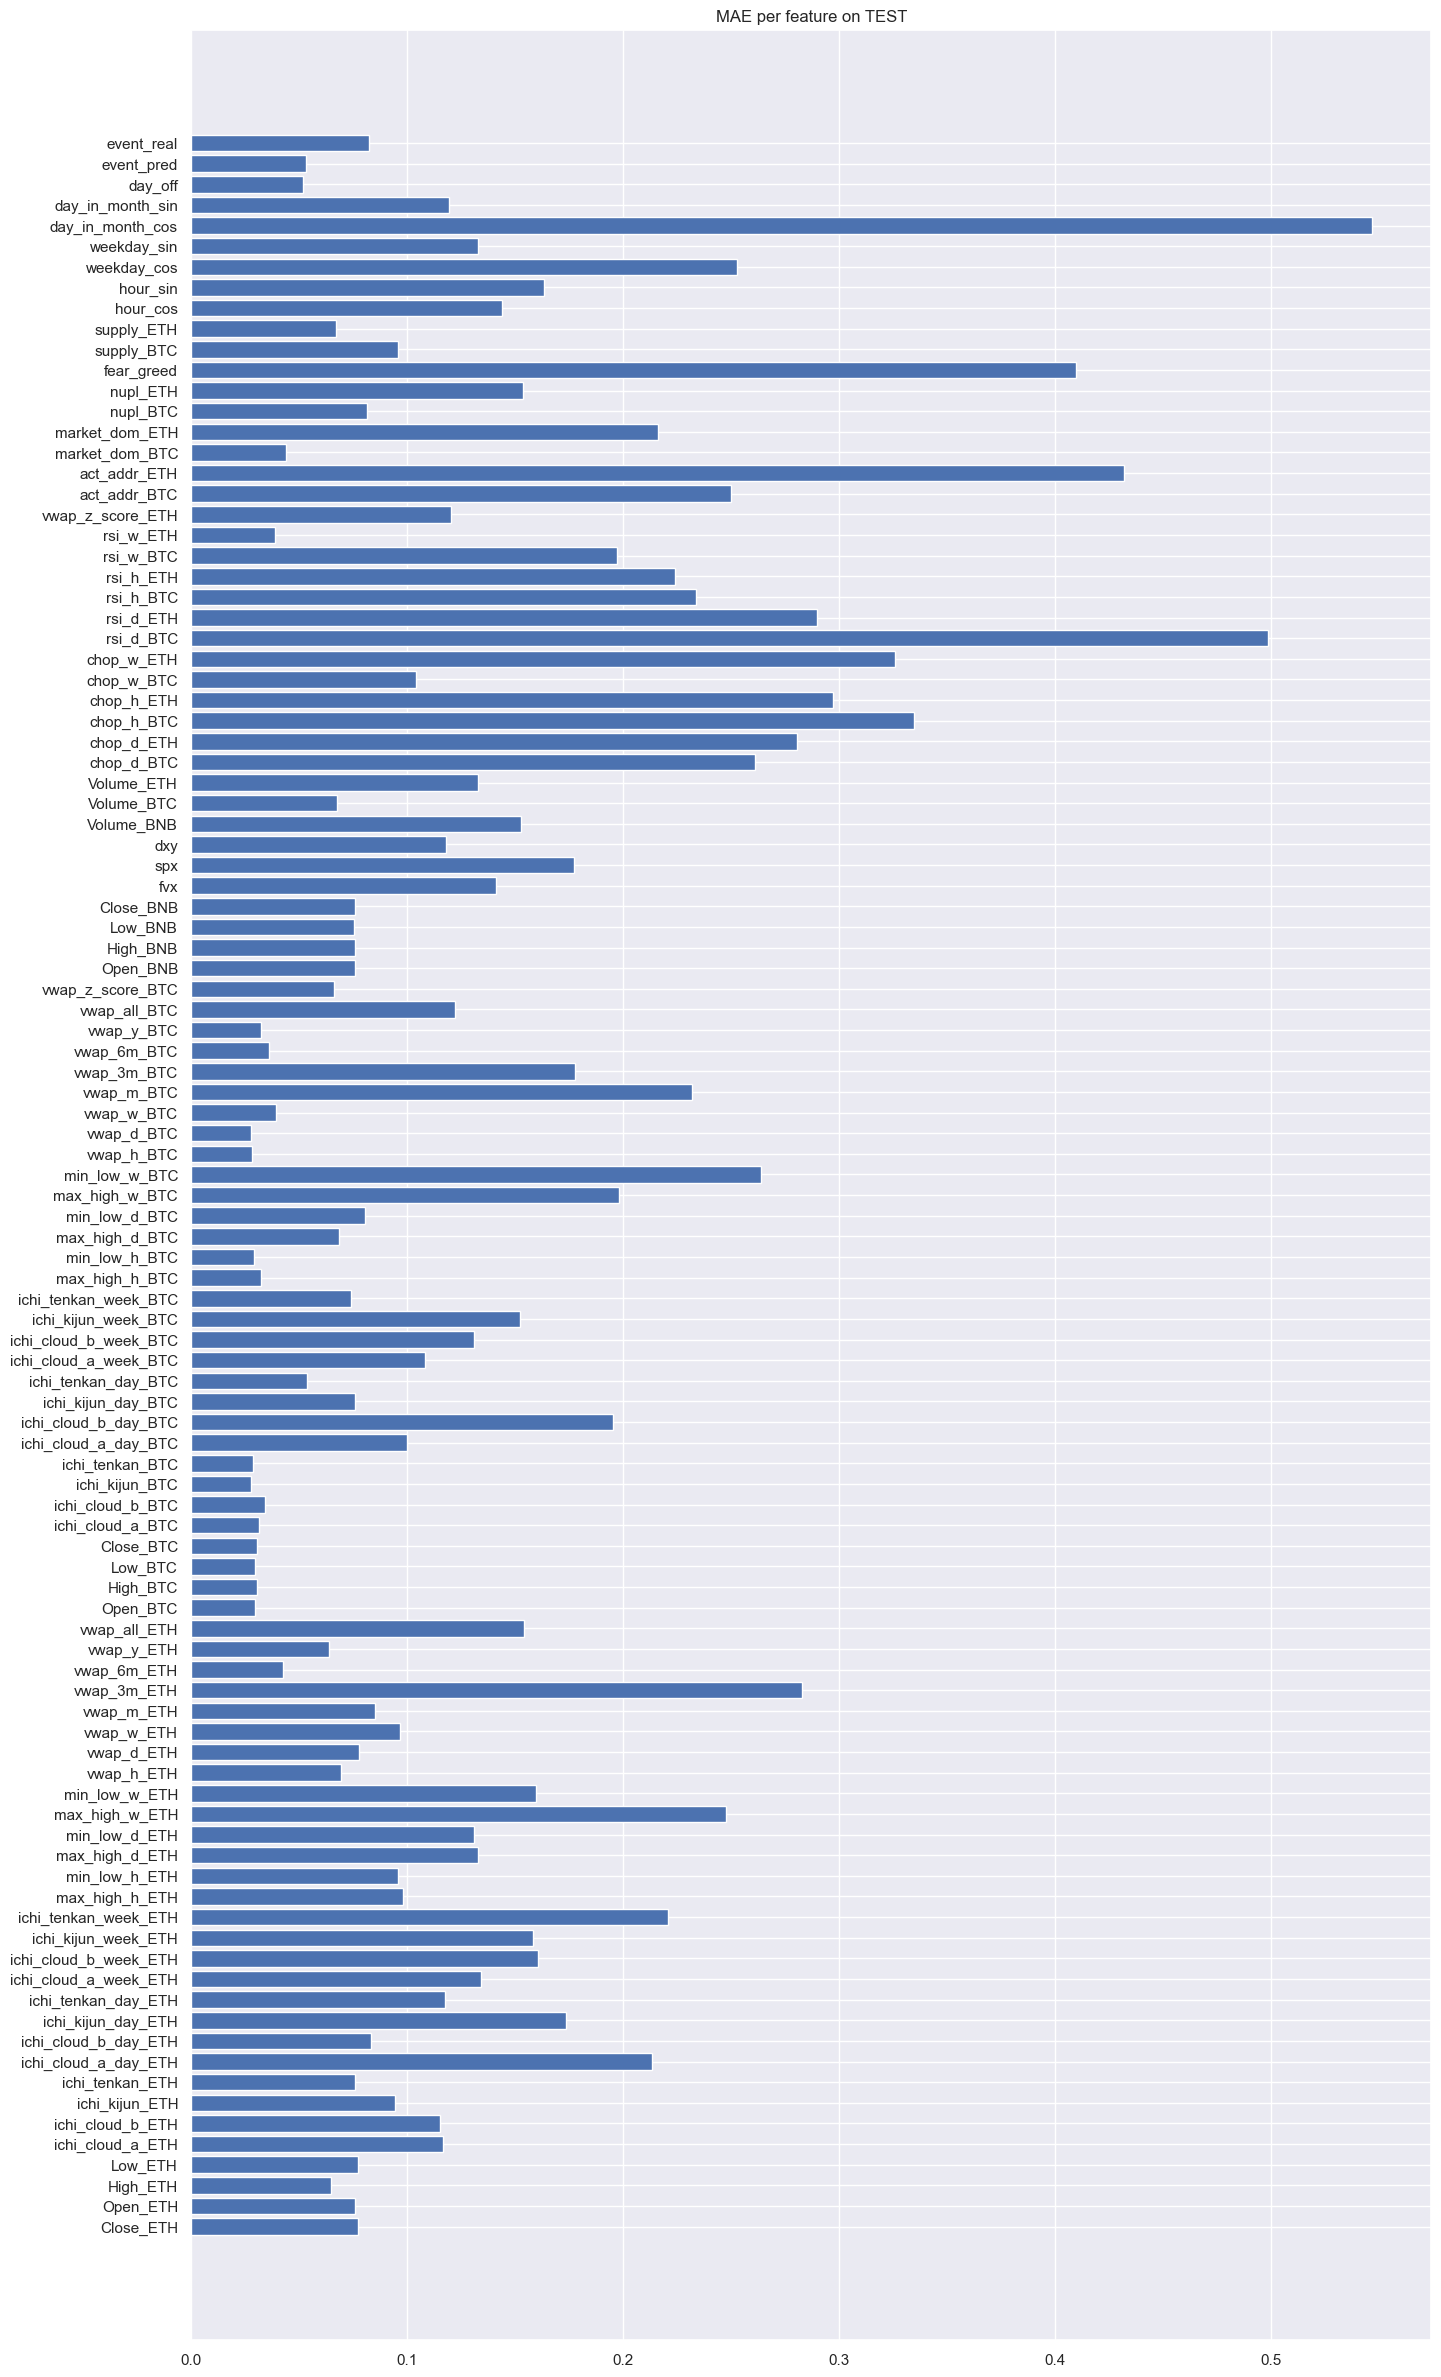

In [119]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [120]:
df_mae_ae_test_feat.values[0]

array([0.07724382, 0.07596651, 0.06458135, 0.07715405, 0.11632801,
       0.11517966, 0.09442327, 0.07594203, 0.21318717, 0.08310998,
       0.17363161, 0.11734591, 0.13395295, 0.16059162, 0.15827574,
       0.22069628, 0.09780635, 0.09578954, 0.13262763, 0.13099621,
       0.24759242, 0.15979866, 0.0695309 , 0.07777984, 0.09652268,
       0.08484069, 0.28264538, 0.04261851, 0.06375877, 0.15388011,
       0.02951047, 0.03052976, 0.02941156, 0.0302262 , 0.03124428,
       0.03391853, 0.027548  , 0.02865155, 0.10001267, 0.19512412,
       0.0759902 , 0.05346532, 0.10830062, 0.13084038, 0.1519912 ,
       0.07406045, 0.03245363, 0.02899887, 0.06831687, 0.08056916,
       0.19825598, 0.26379986, 0.02814116, 0.02778885, 0.03903076,
       0.23176365, 0.17753285, 0.03591266, 0.03218445, 0.12203444,
       0.06593271, 0.07564244, 0.07555852, 0.07514817, 0.07576101,
       0.14122742, 0.17733362, 0.11779009, 0.15252098, 0.06751188,
       0.13292531, 0.26083641, 0.28030423, 0.33445463, 0.29712

In [121]:
2/df_mae_ae_test_feat.values[0].sum()

0.14442499104375425

In [122]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.144374
1       TRAIN   Close_ETH  0.117965
2       TRAIN   Close_ETH  0.111114
3       TRAIN   Close_ETH  0.106072
4       TRAIN   Close_ETH  0.103177
...       ...         ...       ...
14683    TEST  event_real  0.077472
14684    TEST  event_real  0.077493
14685    TEST  event_real  0.077424
14686    TEST  event_real  0.077398
14687    TEST  event_real  0.077362

[14688 rows x 3 columns]

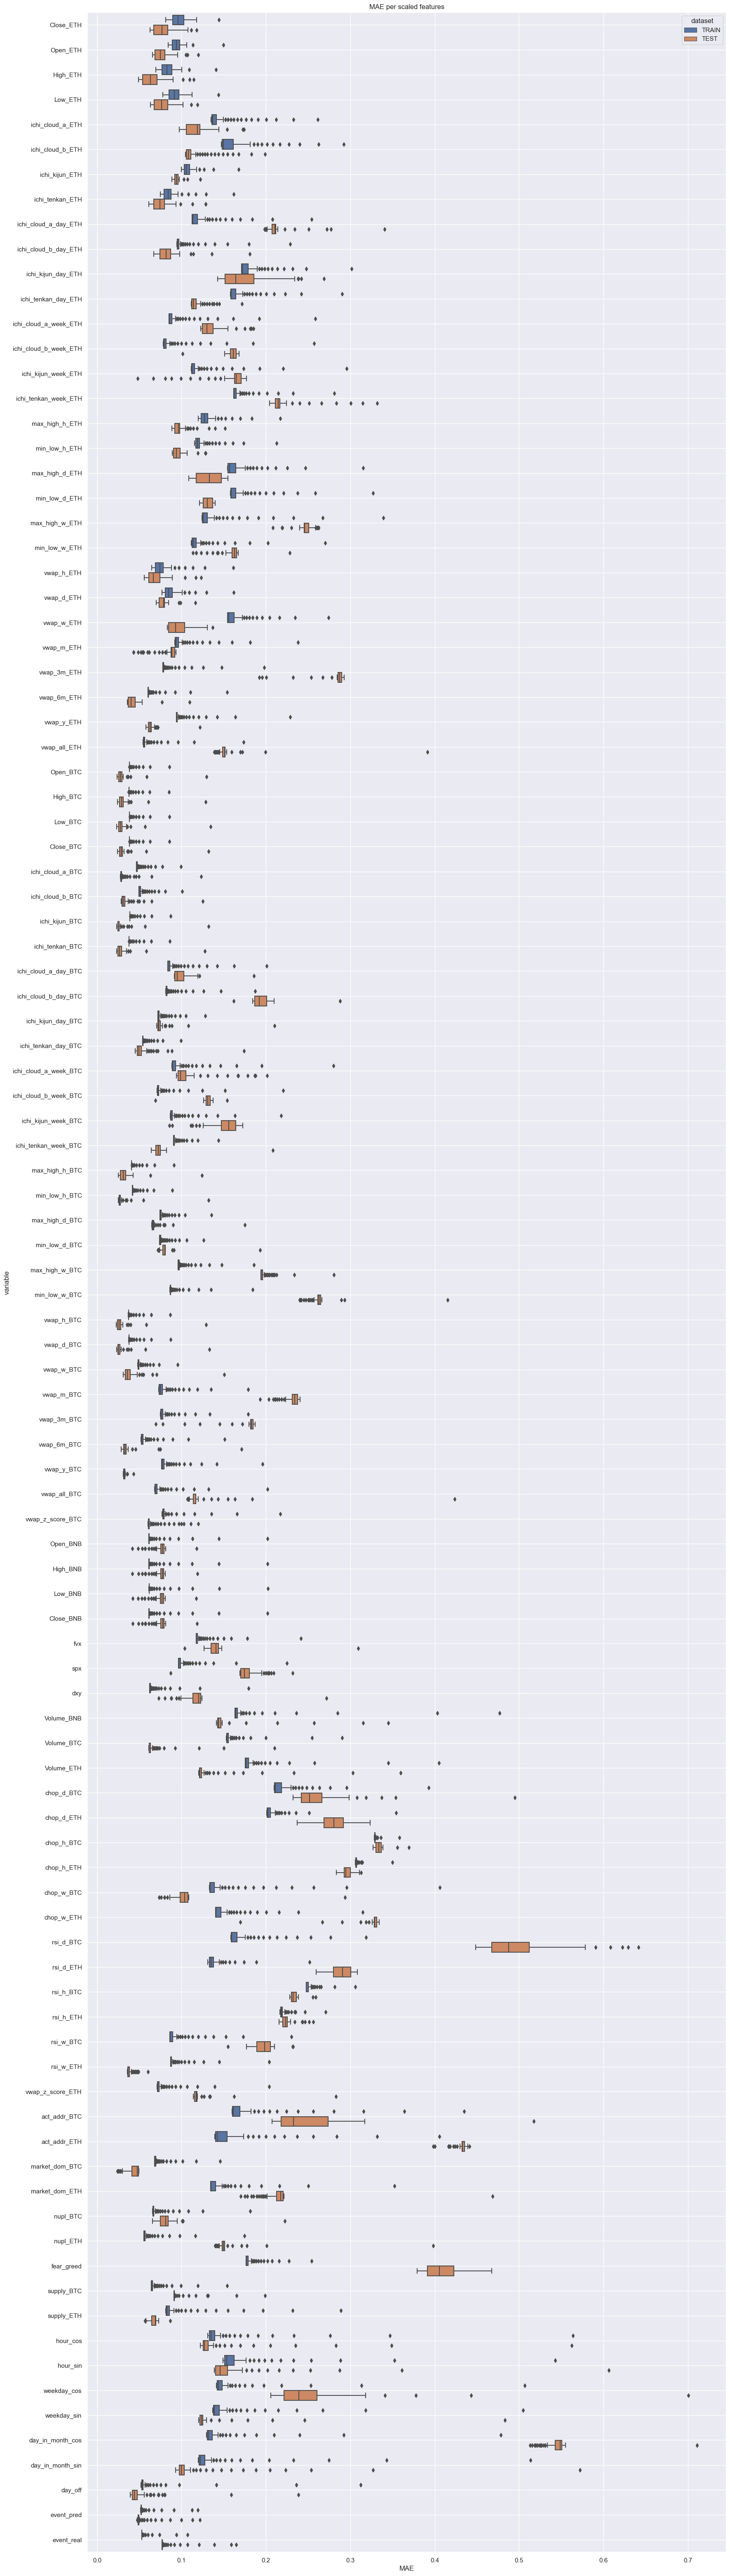

In [123]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [124]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(76846, 72, 102)
(76846, 72, 102)
(72, 102)
(689, 72, 102)
(689, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [125]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.022674  0.022415   0.01700  0.020140          0.080127   
0   0.010171  0.010198   0.00764  0.009815          0.025152   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.082670        0.027904         0.017919              0.028255   
0          0.021159        0.013966         0.010264              0.053796   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.020441  ...  0.038866  0.047621     0.041873     0.041503   
0              0.012164  ...  0.034372  0.044241     0.092591     0.031098   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.034011          0.034353  0.022252    0.974680    0.985553   
0          0.314288          0.026347  0.005835    0.004008    0.007734   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

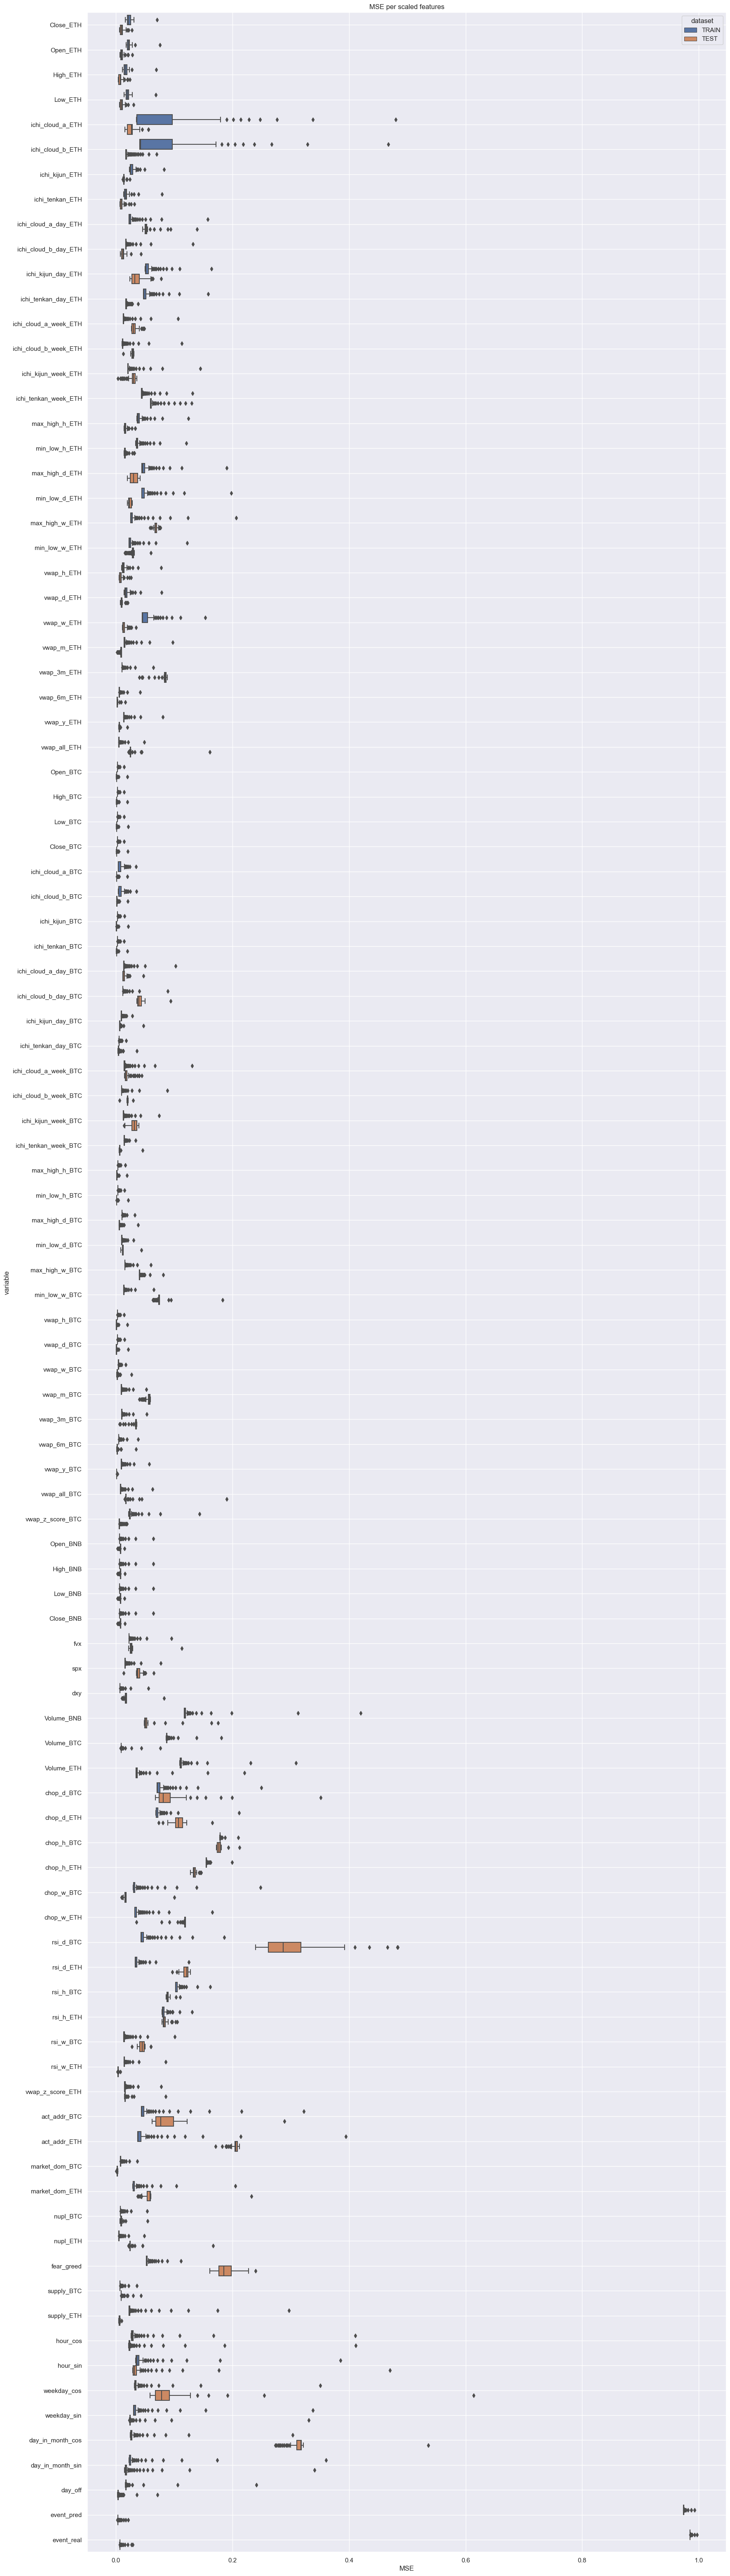

In [126]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

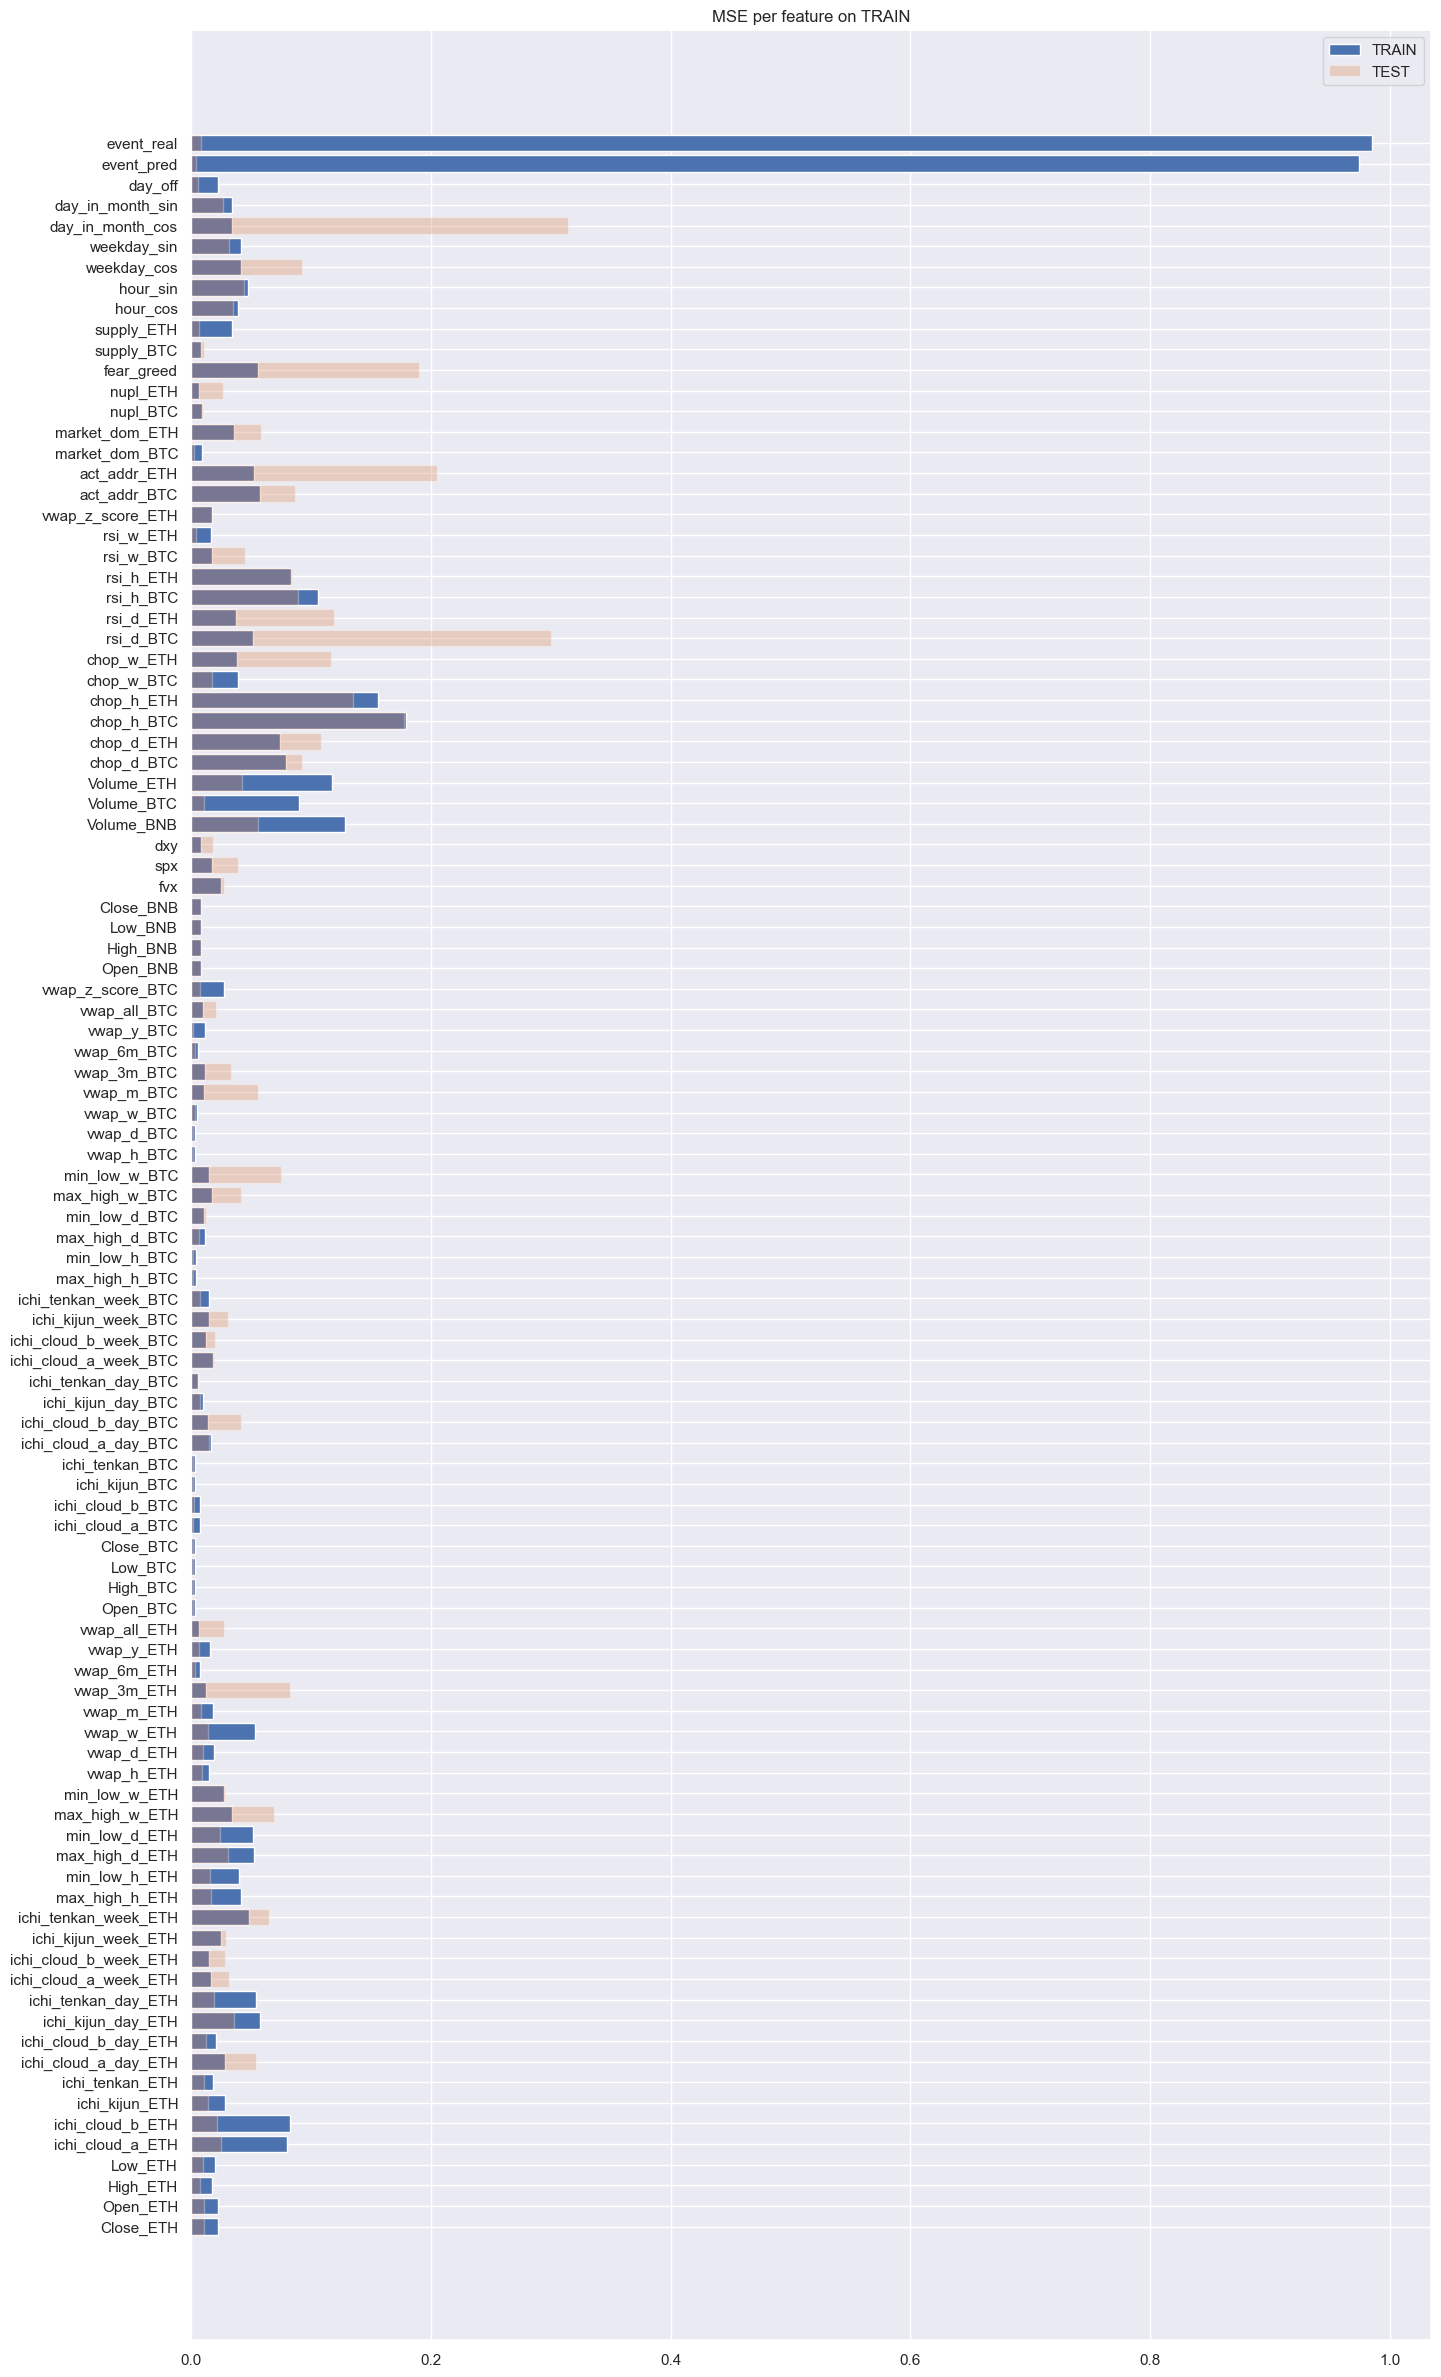

In [127]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [128]:
encoder_model.layers[3].get_weights()

[array([[-0.01705348, -0.05558364, -0.27636603, ..., -0.19030115,
          0.15947744,  0.16131806],
        [-0.11986547,  0.30509937,  0.23429081, ..., -0.07418764,
         -0.09255379,  0.30058   ],
        [-0.5184599 , -0.1750743 , -0.3839842 , ..., -0.20223086,
          0.05074093,  0.0836025 ],
        ...,
        [-0.0971245 , -0.07267982, -0.22459976, ...,  0.30923575,
         -0.07242865,  0.10416933],
        [-0.18471801,  0.18805592, -0.03699083, ..., -0.18789041,
         -0.36862838,  0.02054311],
        [-0.00219896,  0.28260943,  0.33200768, ..., -0.13091664,
         -0.0502673 , -0.23013759]], dtype=float32),
 array([-0.03811632,  0.01345427, -0.19828616, -0.35161924, -0.16724394,
        -0.32797223,  0.2835309 ,  0.45782968,  0.35909745,  0.23698388,
         0.12472219,  0.18535876, -0.17492831,  0.32537162,  0.10899549,
         0.00181803], dtype=float32)]

## Prediction Models

### LSTM all features

In [129]:
X_train_sca.shape

(76846, 72, 102)

In [130]:
X_train_sca.shape[-1]

102

In [131]:
X_train_sca.shape[-2:]

(72, 102)

In [132]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [133]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [134]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2402/2402 [==============================] - 28s 11ms/step


(76846, 72, 16)

In [135]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

 1/22 [>.............................] - ETA: 0s

22/22 [==============================] - 0s 16ms/step


(689, 72, 16)

In [136]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



In [137]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [138]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [139]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((76846, 72, 20), (689, 72, 20))

#### Correlations

In [140]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



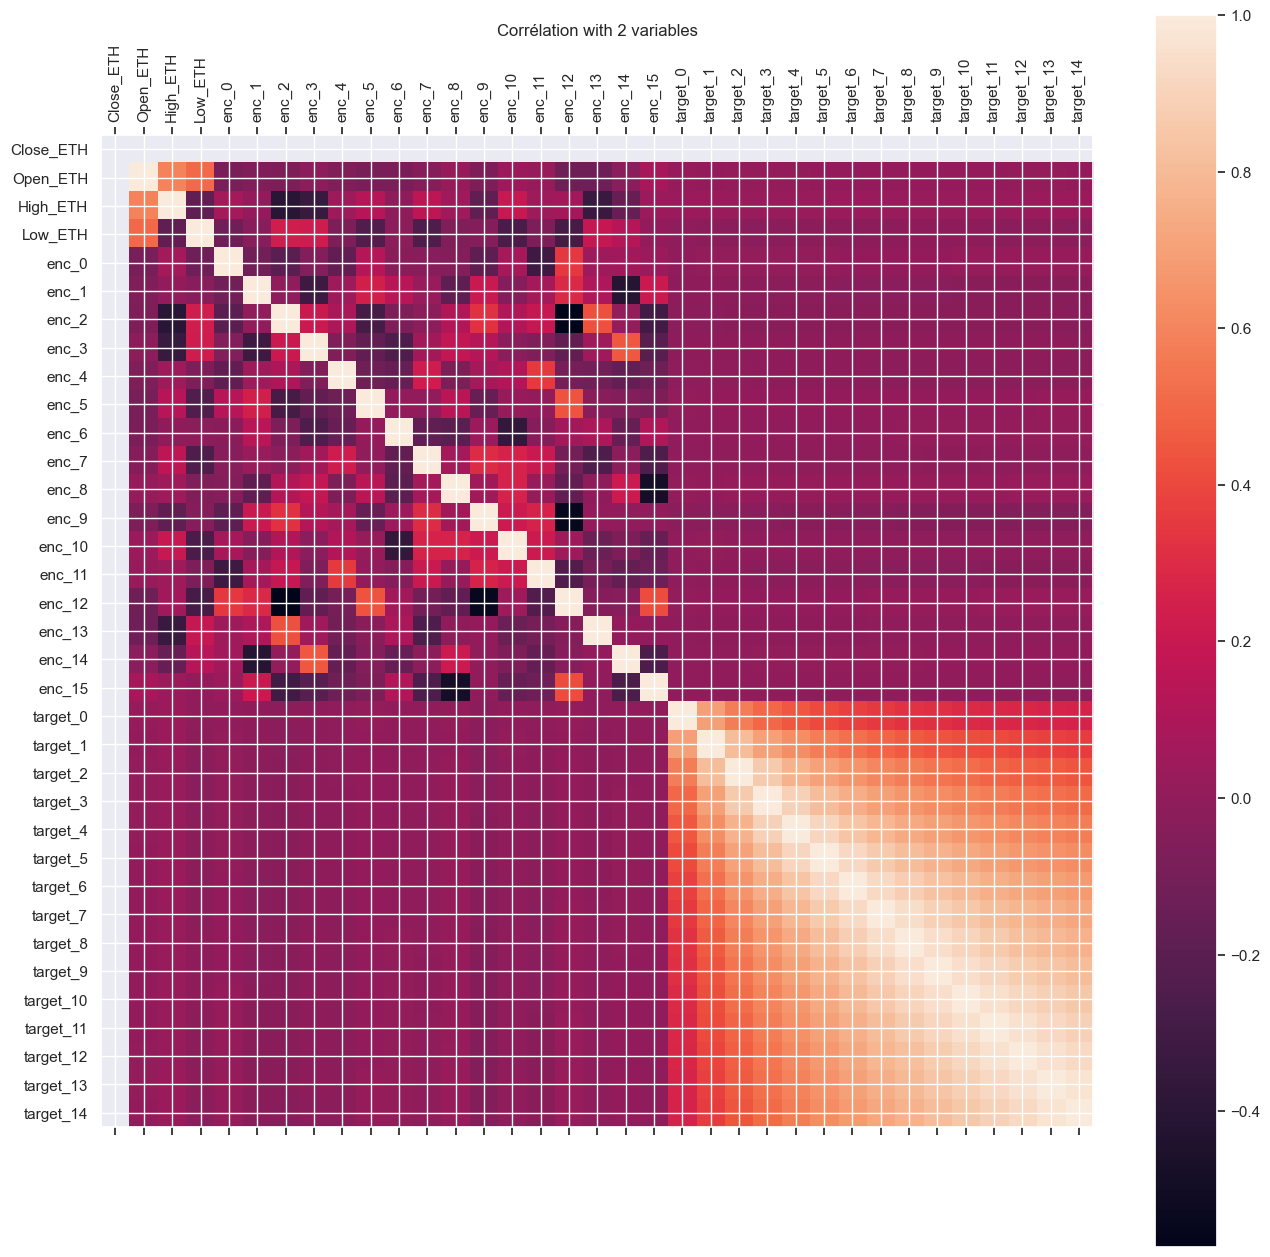

In [141]:
fig = plot_corr(corr_matrix_min)

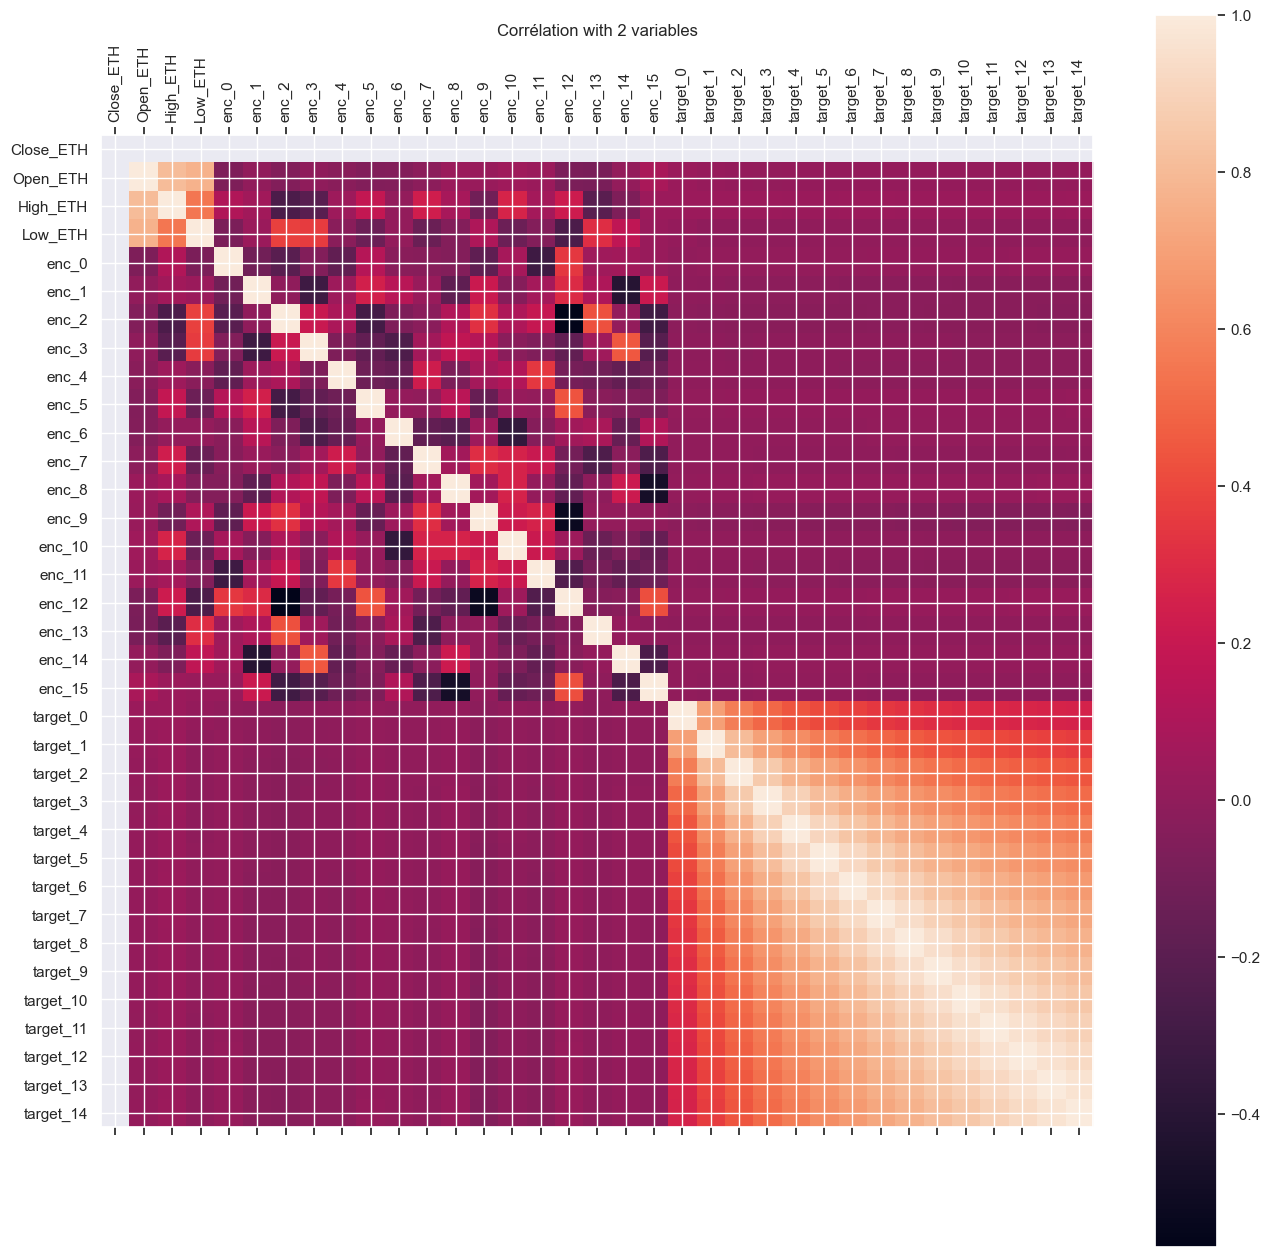

In [142]:
fig = plot_corr(corr_matrix_max) 

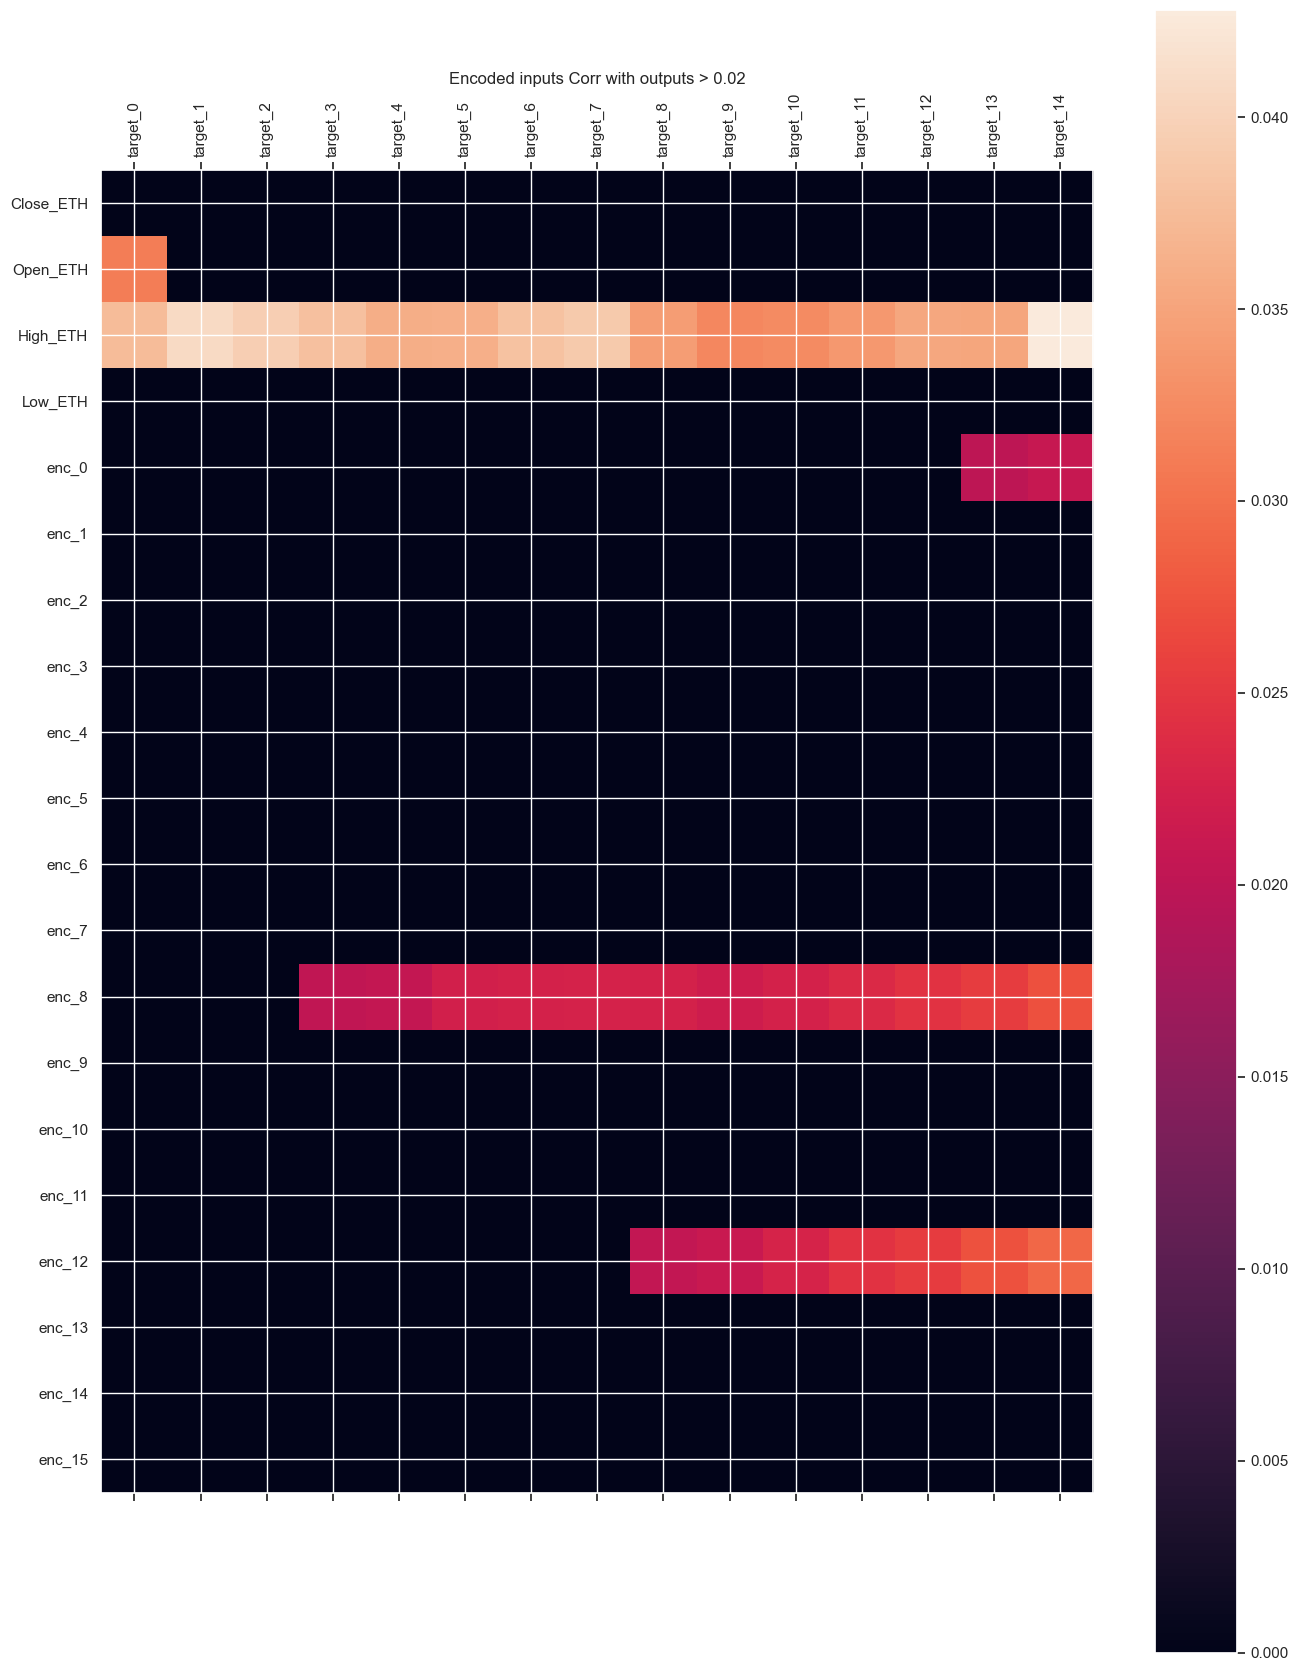

In [143]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

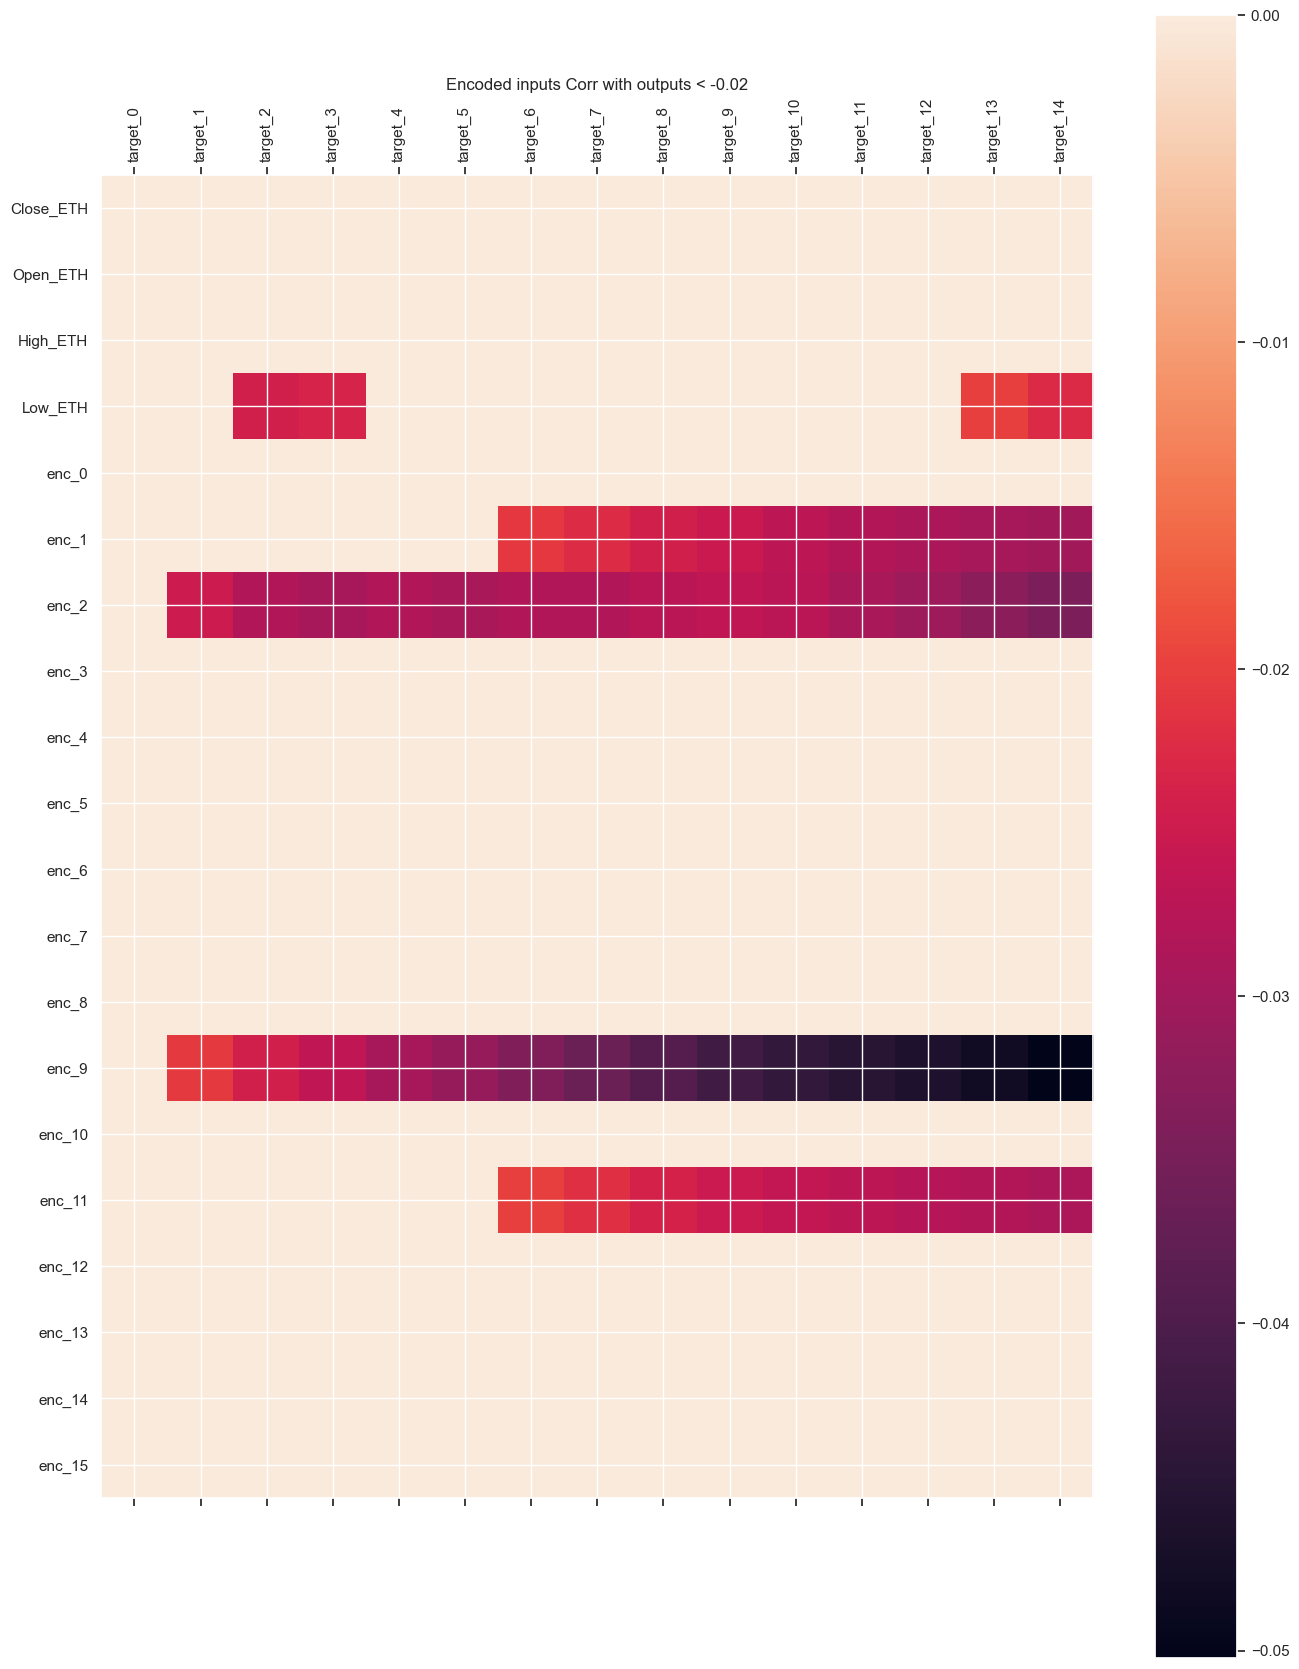

In [144]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [145]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [146]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [147]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [148]:
MODE_AUTO_SELECT

0

In [149]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
nb encoded features:  16


In [150]:
X_train_.shape

(76846, 72, 20)

In [151]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [152]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [153]:
X_train_.shape

(76846, 72, 20)

#### Train

Epoch 1/100
1201/1201 [==============================] - 28s 22ms/step - loss: 1.0690 - val_loss: 0.4492
Epoch 2/100
1201/1201 [==============================] - 27s 22ms/step - loss: 0.9894 - val_loss: 0.4586
Epoch 3/100
1201/1201 [==============================] - 26s 22ms/step - loss: 0.9674 - val_loss: 0.4691
Epoch 4/100
1201/1201 [==============================] - 26s 22ms/step - loss: 0.9388 - val_loss: 0.4597
Epoch 5/100
1201/1201 [==============================] - 26s 21ms/step - loss: 0.9141 - val_loss: 0.4463
Epoch 6/100
1201/1201 [==============================] - 26s 22ms/step - loss: 0.8897 - val_loss: 0.4584
Epoch 7/100
1201/1201 [==============================] - 26s 22ms/step - loss: 0.8578 - val_loss: 0.4733
Epoch 8/100
1201/1201 [==============================] - 26s 21ms/step - loss: 0.8205 - val_loss: 0.4795
Epoch 9/100
1201/1201 [==============================] - 26s 21ms/step - loss: 0.7861 - val_loss: 0.4674
Epoch 10/100
1201/1201 [==============================]

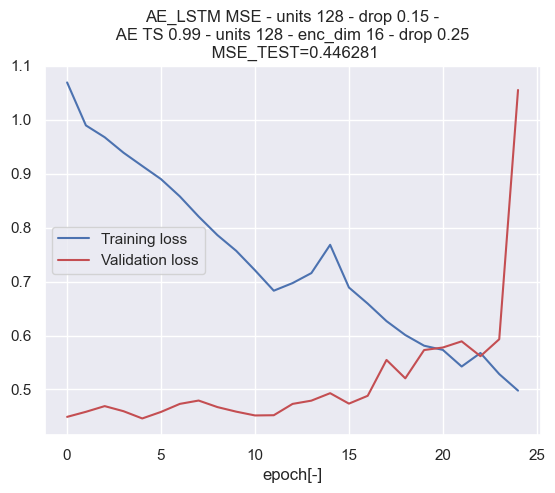

Save model:  data/mdl_predict_autoenc_lstm
INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


In [154]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100#30
patience = 20#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)
seed = 1
mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.15]: #[0.05, 0.15, 0.25]: #[0.1]:

            tf.keras.backend.clear_session()
            np.random.seed(seed)
            random.seed(seed)
            tf.random.set_seed(seed)
            optim = tf.keras.optimizers.legacy.Adam()
            #optim = tf.keras.optimizers.AdamW()
            if patience is not None:
                es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                verbose=1, patience=patience,
                                                restore_best_weights=True)
            # create model
            multi_step_model = tf.keras.models.Sequential()
            multi_step_model.add(
                tf.keras.layers.LSTM(
                    n_units,
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:],
                    #kernel_regularizer=reg,
                    #bias_regularizer=reg,
                )
            )
            multi_step_model.add(tf.keras.layers.LayerNormalization())
            multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
            #multi_step_model.add(tf.keras.layers.BatchNormalization())
            multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
            # compile
            multi_step_model.compile(optimizer=optim, loss='mse')
            # fitting
            if patience == 0:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1,
                )
            else:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1, 
                    callbacks=[es],
                )
            # eval
            mse_curr = np.min(multi_step_history.history['val_loss'])
            print("MSE TEST : ", mse_curr)

            # plot MSE
            name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            plot_train_history(
                multi_step_history,
                f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                saveFolder="data",
            )

            # save the best
            if mse_curr_min == None:
                mse_curr_min = mse_curr
                n_units_min = n_units
                dropout_rate_min = dropout_rate

                print("Save model: ", path_mdl_predict_autoenc_lstm)
                multi_step_model.save(path_mdl_predict_autoenc_lstm)
            else:
                if mse_curr < mse_curr_min:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate
                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

else:
    
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    n_units = multi_step_model.layers[0].units#32
    dropout_rate = multi_step_model.layers[2].rate#0.25
    print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
    print(multi_step_model.summary())

In [155]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.15


In [156]:
np.min(y_train)

0.8990060972444147

In [157]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [158]:
X_train_.shape

(76846, 72, 20)

##### Predict

In [159]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

22/22 [==============================] - 0s 17ms/step


##### Plots

In [160]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(76860,)
(76860,)


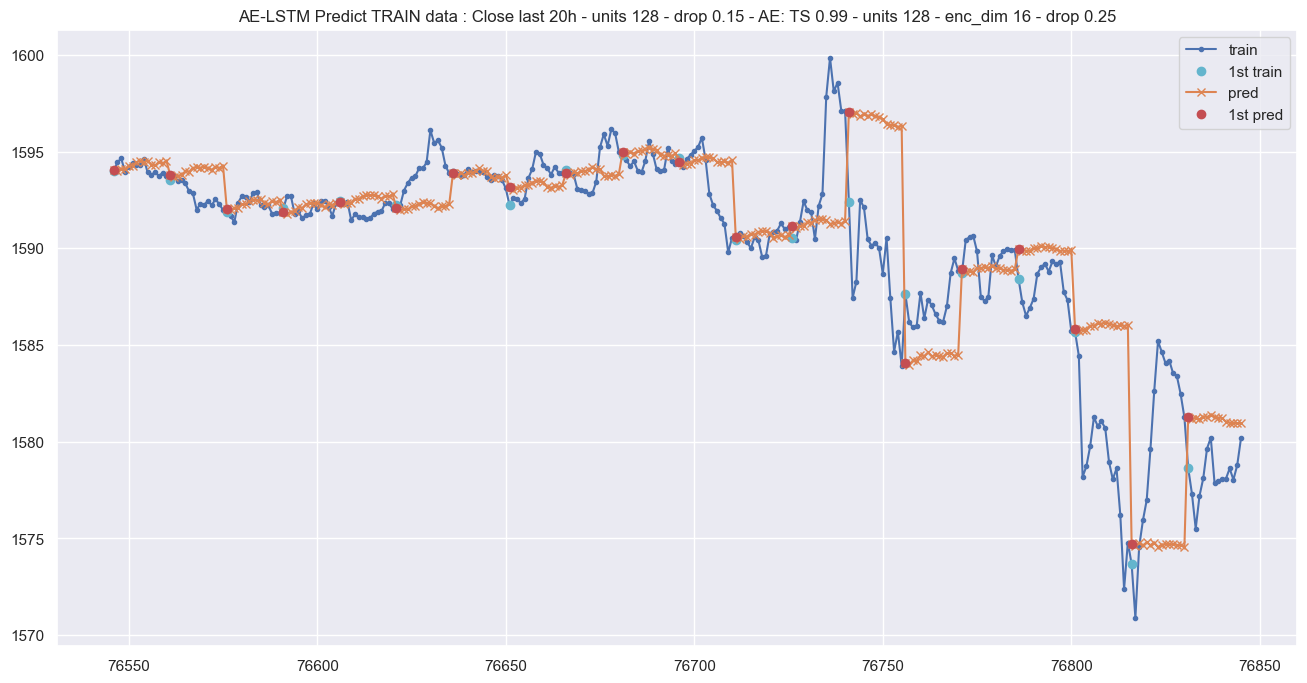

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

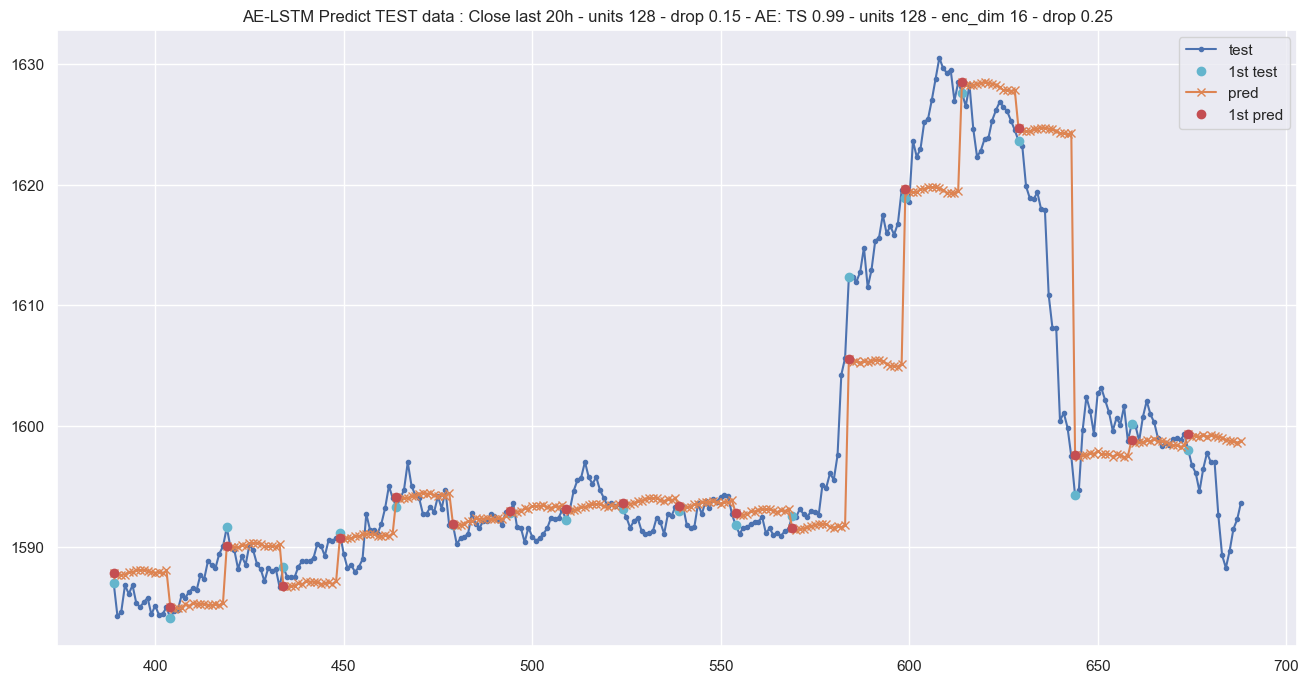

In [162]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

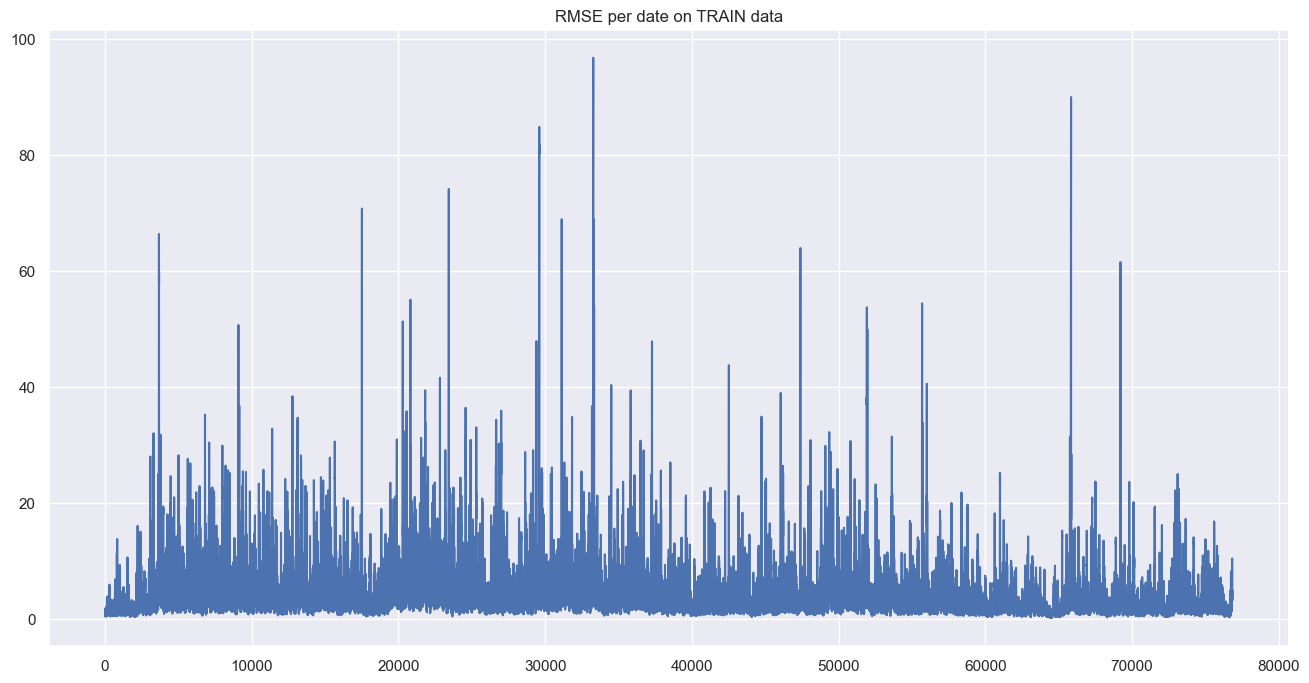

In [163]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

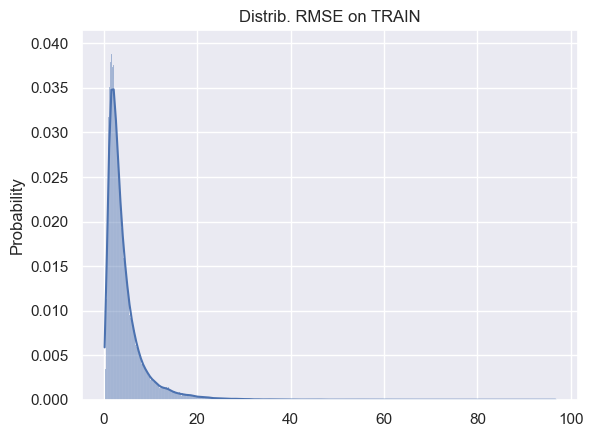

In [164]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.42')

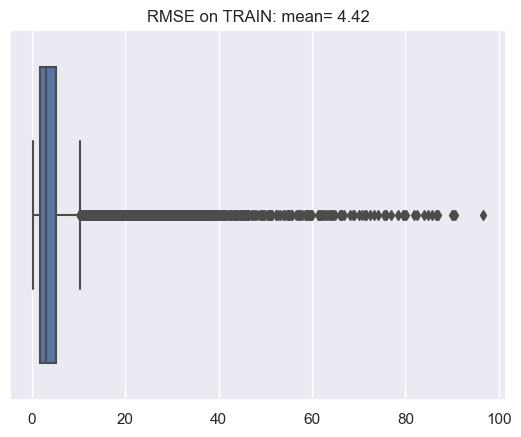

In [165]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

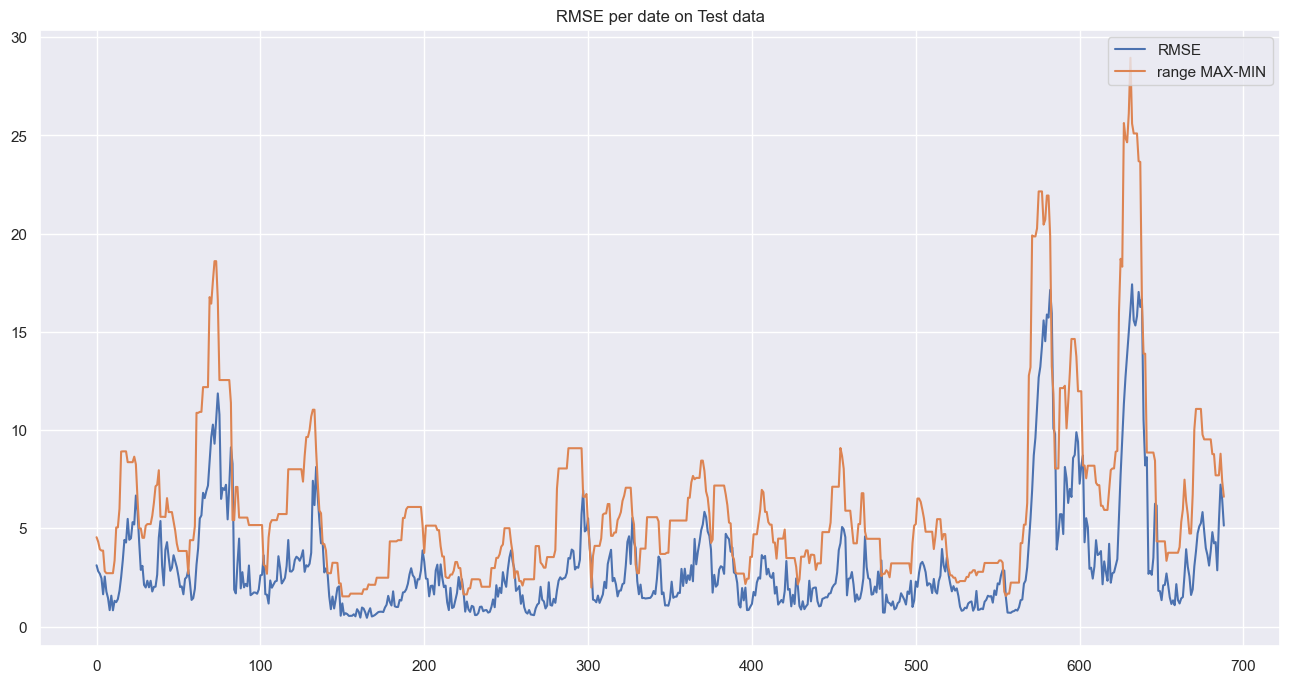

In [166]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [167]:
np.mean(arr_range)

6.095224963715527

<AxesSubplot: ylabel='Probability'>

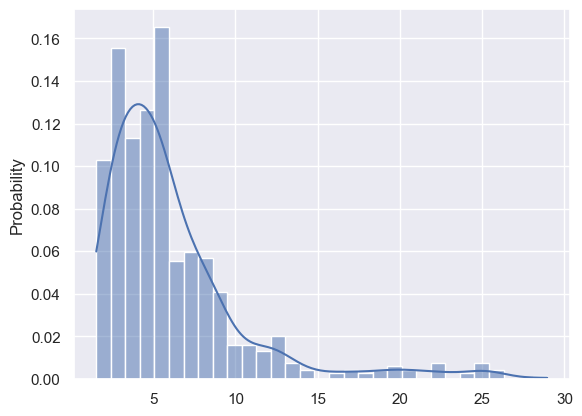

In [168]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [169]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

5.4475565619813695

<AxesSubplot: ylabel='Probability'>

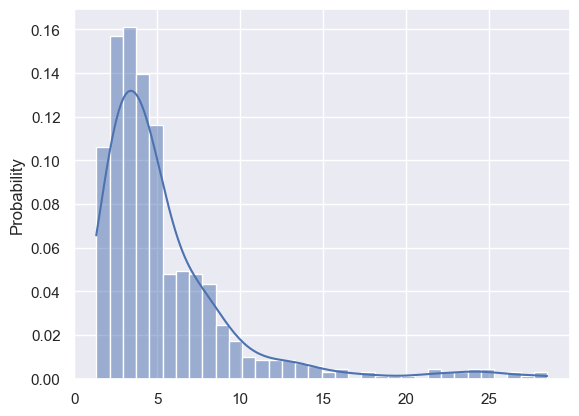

In [170]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

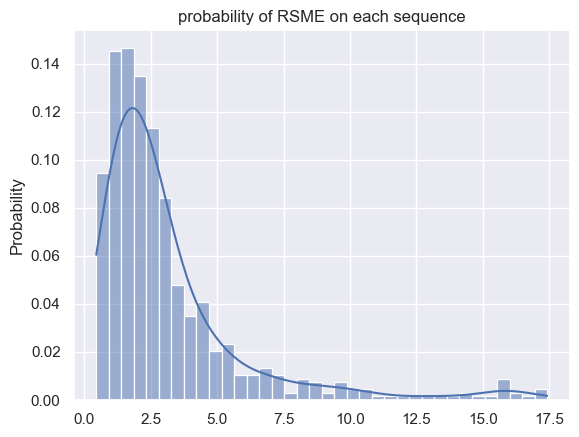

In [171]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 30.476124818577635)

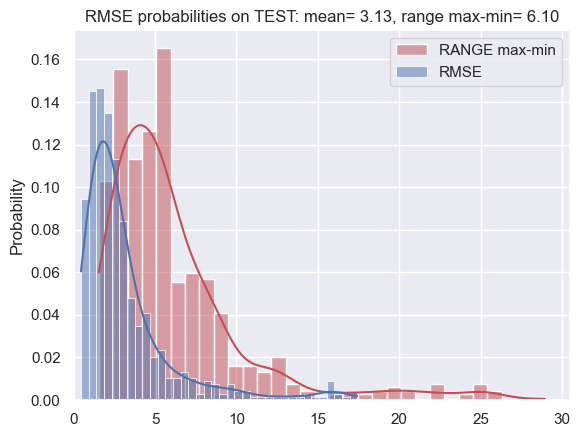

In [172]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 15.671492366783749)

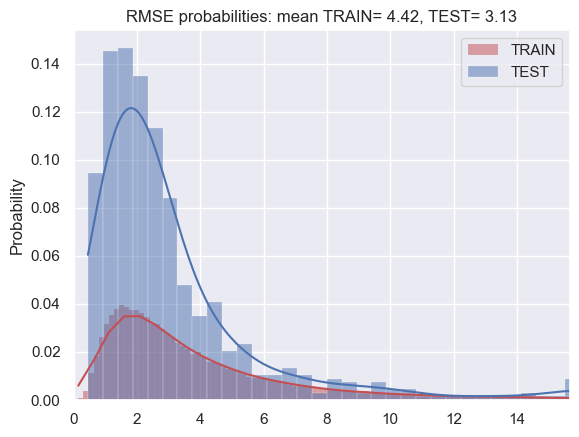

In [173]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 3.13')

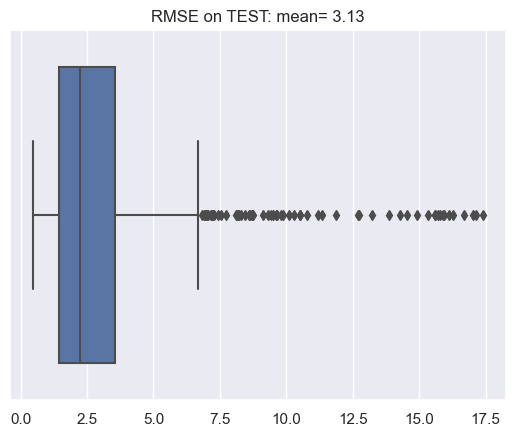

In [174]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [175]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1589.67 1591.48 1592.27 1593.66 1595.96 1595.75 1595.22 1595.58 1594.47
 1595.4  1595.82 1595.63 1595.64 1595.33 1598.47]
[1588.17849113 1587.93547922 1588.08098343 1587.9311245  1587.9747663
 1587.80644718 1588.0312829  1587.69720068 1587.76271071 1587.69653801
 1587.55576718 1587.78495762 1587.63680271 1587.44008328 1587.64674281]


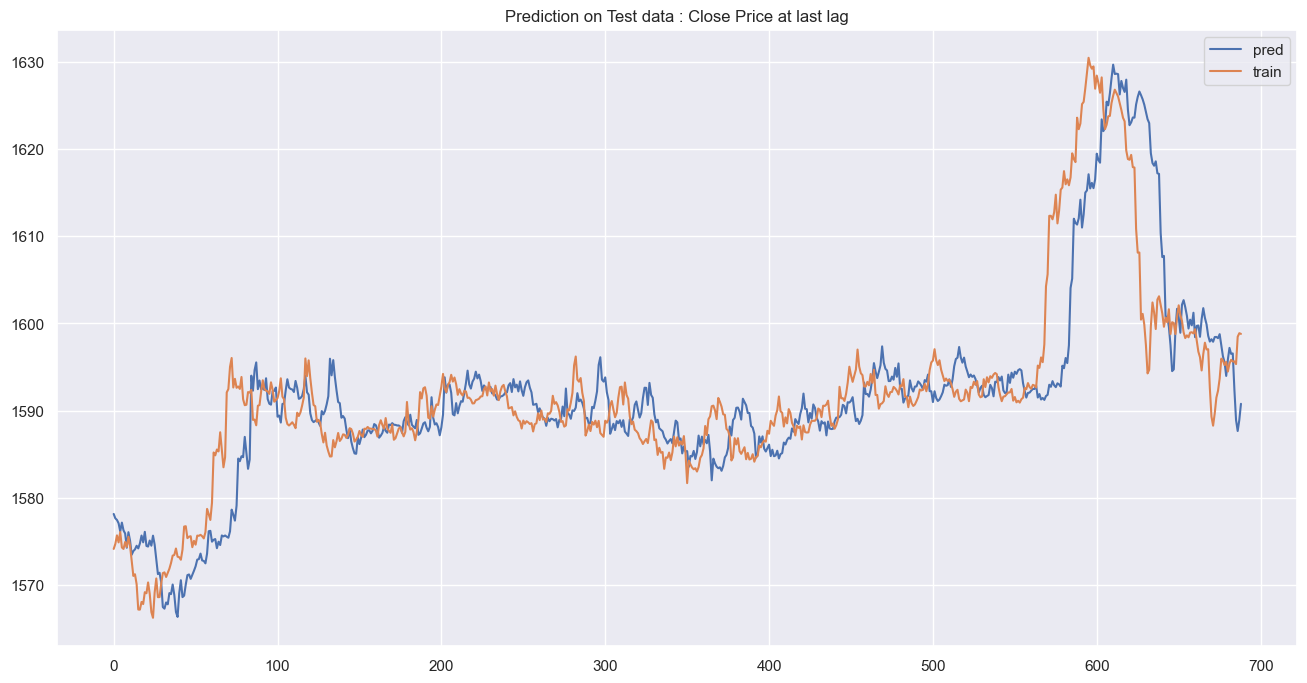

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

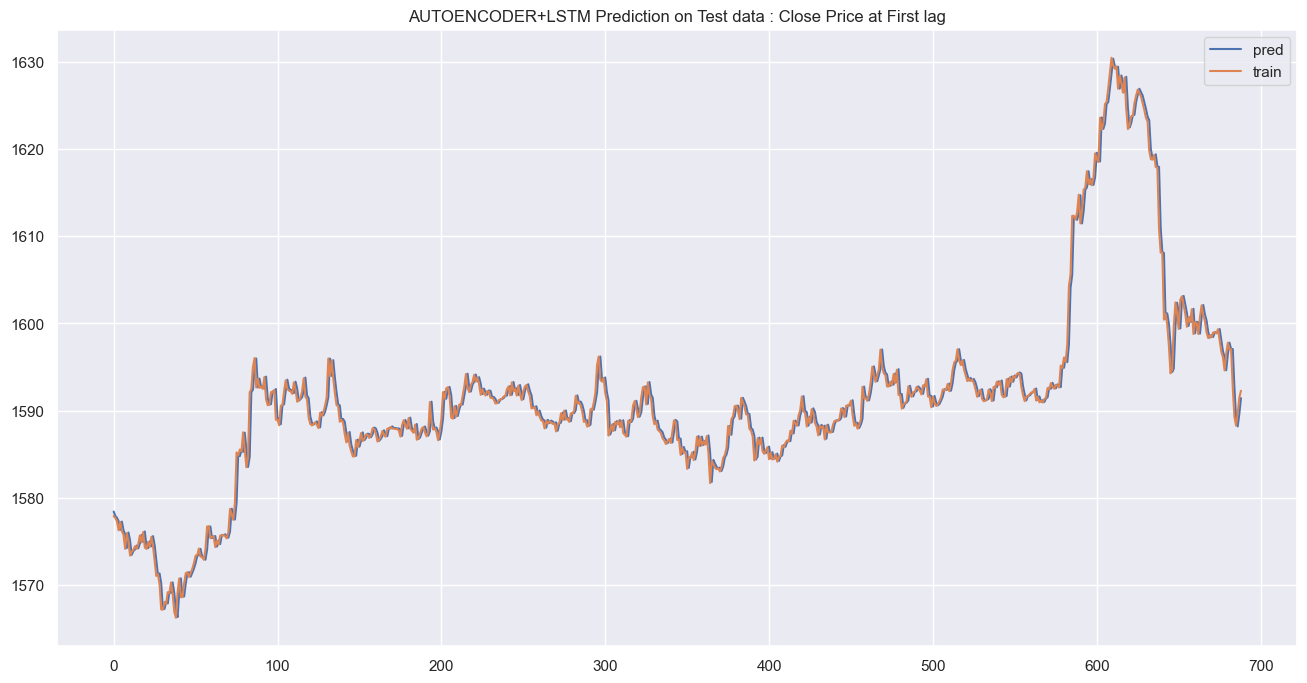

In [177]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

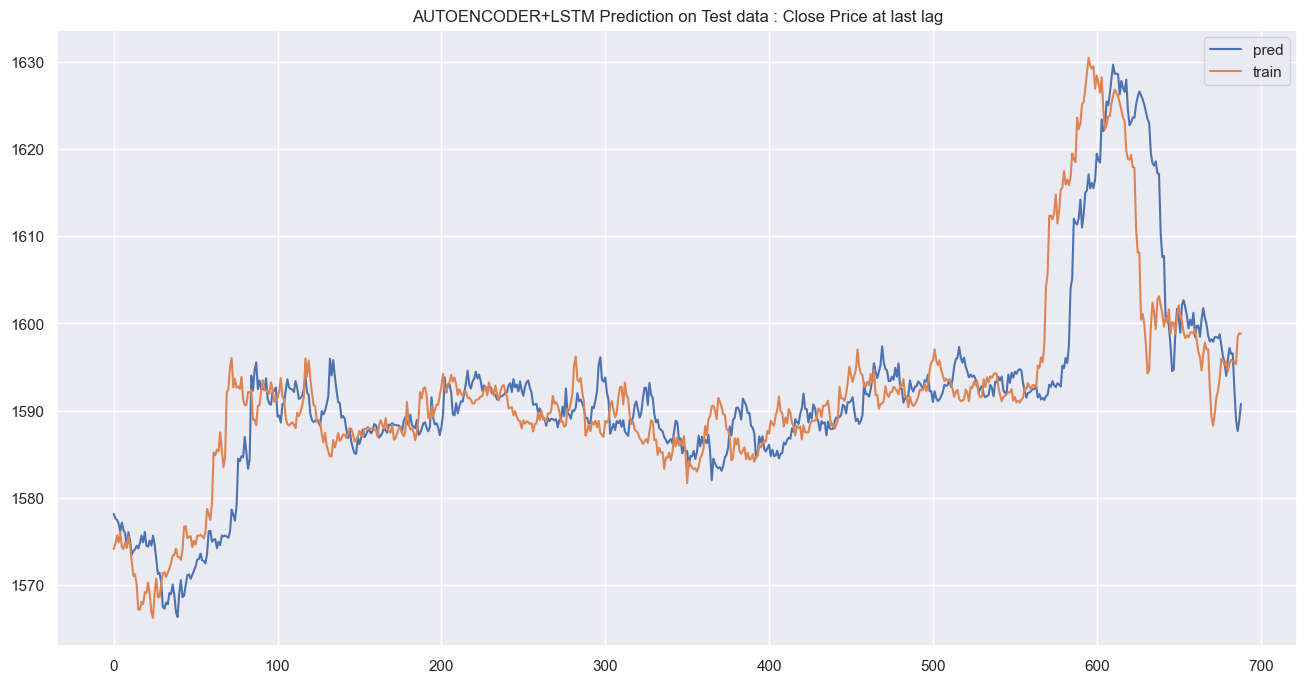

In [178]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [179]:
X_test_sca.shape

(689, 72, 102)

In [180]:
df_feat["Close_ETH"].iloc[-1]

1597.99

In [181]:
df_feat["Close_ETH"].iloc[-1]

1597.99

In [182]:
len(list_i_enc_select)

16

In [183]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1619.86 1618.88 1618.8  1619.36 1617.95 1617.91 1610.87 1608.13 1608.15
 1600.44 1601.1  1599.88 1597.5  1594.26 1594.68 1599.64 1602.41 1601.26
 1599.36 1602.74 1603.12 1602.13 1601.14 1599.62 1600.68 1600.13 1601.63
 1598.78 1600.14 1600.05 1598.78 1600.77 1602.08 1600.97 1600.3  1598.98
 1598.32 1598.63 1598.41 1598.95 1598.99 1598.85 1599.34 1598.03 1596.76
 1596.12 1594.6  1596.48 1597.79 1597.01 1597.04 1592.61 1589.3  1588.26
 1589.67 1591.48 1592.27 1593.66 1595.96 1595.75 1595.22 1595.58 1594.47
 1595.4  1595.82 1595.63 1595.64 1595.33 1598.47 1598.88 1598.8  1597.99]
X_last[0,:,0] after divide by price:
[1.01368594 1.01307267 1.01302261 1.01337305 1.01249069 1.01246566
 1.00806013 1.00634547 1.00635799 1.00153318 1.00194619 1.00118274
 0.99969336 0.99766582 0.99792865 1.00103255 1.00276597 1.00204632
 1.00085733 1.00297248 1.00321028 1.00259075 1.00197123 1.00102003
 1.00168336 1.00133918 1.00227786 1.00049437 1.00134544 1.00128912
 1.0

In [184]:
X_last_encoded_sca.shape

(1, 72, 16)

In [185]:
list_i_enc_select

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [186]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 16)

In [187]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [188]:
X_train_.shape

(76846, 72, 20)

In [189]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
77704  1695842400000   1595.63   1597.12  1595.32    1595.33   1015.2508   
77705  1695842700000   1595.33   1600.00  1595.32    1598.47   1678.5413   
77706  1695843000000   1598.46   1598.88  1597.97    1598.88    219.2857   
77707  1695843300000   1598.88   1598.94  1598.17    1598.80    272.7304   
77708  1695843600000   1598.80   1598.80  1597.98    1597.99    116.0932   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1735.918623       1735.480578   
1      2023-01-01 00:05:00       1735.918623       1735.480578   
2      2023-01-01 00:10:00       1735.918623       1735.480578   
3      2023-01-01 00:15:00       1735.918623       1735.480578   
4      2023-01-01 00:20:00       1735.918623       1735.480578   
...                    ...               ...               ...   
77704  2023-09-27 19:20:00       1600.310000       1610.475000   
77705  2023-09-27 19:25:00       1599.755000       1610.475000   
77706  2023-09-27 19:30:00       1599.497500       1610.475000   
77707  2023-09-27 19:35:00       1599.152500       1610.475000   
77708  2023-09-27 19:40:00       1598.805000       1610.080000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
77704         1591.53  ...         NaN            NaN           NaN   
77705         1591.75  ...         NaN            NaN           NaN   
77706         1591.75  ...         NaN            NaN           NaN   
77707         1591.75  ...         NaN            NaN           NaN   
77708         1591.75  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
77704               NaN         0.0               NaN         0.0      0.0   
77705               NaN         0.0               NaN         0.0      0.0   
77706               NaN         0.0               NaN         0.0      0.0   
77707               NaN         0.0               NaN         0.0      0.0   
77708               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
77704                  NaN  False  
77705                  NaN  False  
77706                  NaN  False  
77707                  NaN  False  
77708                  NaN  False  

[77709 rows x 136 columns]

In [190]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [191]:
y_last_pred_unscaled

array([[1.0000299 , 0.9998982 , 0.9998866 , 0.9998448 , 0.9999814 ,
        0.99994195, 1.0000362 , 0.9999728 , 0.9999676 , 0.999912  ,
        0.99985677, 0.99983066, 0.9997629 , 0.9997224 , 0.99987346]],
      dtype=float32)

In [192]:
df_feat["Close_ETH"].iloc[-1]

1597.99

In [193]:
y_last_pred_raw

array([[1598.0378, 1597.8273, 1597.8087, 1597.742 , 1597.9603, 1597.8972,
        1598.0479, 1597.9465, 1597.9382, 1597.8494, 1597.7611, 1597.7194,
        1597.6111, 1597.5464, 1597.7877]], dtype=float32)

In [194]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [195]:
list_pred

[1597.742,
 1597.9603,
 1597.8972,
 1598.0479,
 1597.9465,
 1597.9382,
 1597.8494,
 1597.7611,
 1597.7194,
 1597.6111,
 1597.5464,
 1597.7877]

In [196]:
save_list(list_pred, path_save_pred_vals)

In [197]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [198]:
list_pred_reload

[1597.742,
 1597.9603,
 1597.8972,
 1598.0479,
 1597.9465,
 1597.9382,
 1597.8494,
 1597.7611,
 1597.7194,
 1597.6111,
 1597.5464,
 1597.7877]